In [1]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=bc42b2fa46e15e9cc83fc87021a7abef21e4cec276c239344889c5402cba62b6
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
The following additional packages will be installed:
  libxtst6 openjdk-8-jre-headless
Suggested packages:
  openjdk-8-demo openjdk-8-source libnss-mdns fonts-dejavu-extra fonts-nanum fonts-ipafont-gothic
  fonts-ipafont-mincho fonts-wqy-microhei fonts-wqy-zenhei fonts-indic
The following NEW packages will be installed:
  libxtst6 openjdk-8-jdk-headless openjdk-8-jre-headless
0 upgraded, 3 newly installed, 0 to remove and 45 not upgraded.
Need to get 39.7 MB of archives.
After this operation, 144 MB of additional disk space will be used.
Selecting previously unselected package

In [2]:
!pip install pmdarima
import pyspark
import pyspark.sql as pyspark_sql
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from pyspark import SparkContext, SparkConf
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, BooleanType
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import numpy as np
from pmdarima.arima import auto_arima
import warnings
warnings.filterwarnings("ignore")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.7 MB/s eta 0:00:00


In [3]:
# create the session
conf = SparkConf().set("spark.ui.port", "4050")

# create the context
sc = pyspark.SparkContext(conf=conf)
spark = pyspark_sql.SparkSession.builder.getOrCreate()

In [4]:
# Load datasets
df = spark.read.csv("Dataset/Preprocessed/cleaned_data.csv", header=True, inferSchema=True)
df_pd = df.toPandas()

In [5]:
def get_data():
    location_df = pd.read_csv('Dataset/Preprocessed/cleaned_data.csv')

    # Convert the Current Date column to datetime
    location_df["Current Date"] = pd.to_datetime(location_df["Current Date"])

    # Sort the DataFrame by the date index
    location_df.sort_values(by="Current Date", inplace=True)

    # Set date as the index
    location_df.set_index("Current Date", inplace=True, drop=True)

    return location_df


In [6]:
def acf_adf(location_df, location_name):
    fig, axes = plt.subplots(3, 1, figsize=(12, 15))
    # Time Series Plot
    location_df.plot(ax=axes[0], y='HCHO reading', grid=True)
    axes[0].set_title(f"HCHO Reading over Time {location_name}")
    axes[0].set_xlabel("Date")
    axes[0].set_ylabel("HCHO Reading")
    axes[0].legend(loc='lower right')

    # ACF Plot (Autocorrelation Function)
    plot_acf(location_df['HCHO reading'], lags=20, ax=axes[1])
    axes[1].set_title(f"Autocorrelation Function (ACF) for {location_name}")
    axes[1].set_xlabel("Lags")
    axes[1].set_ylabel("ACF Value")

    # PACF Plot (Partial Autocorrelation Function)
    plot_pacf(location_df['HCHO reading'], lags=20, ax=axes[2])
    axes[2].set_title(f"Partial Autocorrelation Function (PACF) for {location_name}")
    axes[2].set_xlabel("Lags")
    axes[2].set_ylabel("PACF Value")

    plt.tight_layout()
    plt.show()
    print("\n")

    # Augmented Dickey-Fuller Test (ADF Test)
    adftest = adfuller(location_df['HCHO reading'], autolag='AIC', regression='ct')
    print(f"ADF Test Results {location_name}, \n")
    print("Null Hypothesis: The series has a unit root (non-stationary)")
    print("ADF-Statistic:", adftest[0])
    print("P-Value:", adftest[1])
    print("Number of lags:", adftest[2])
    print("Number of observations:", adftest[3])
    print("Critical Values:", adftest[4])
    print("\n")
    if adftest[1] < 0.05:
      print("Conclusion: ")
      print("Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary ")
    else:
      print("Conclusion: ")
      print("Because P-value is greater than 0.05 , therefore the series is non_stationary ")
    print("\n")


In [7]:
# Load the data
df = get_data()

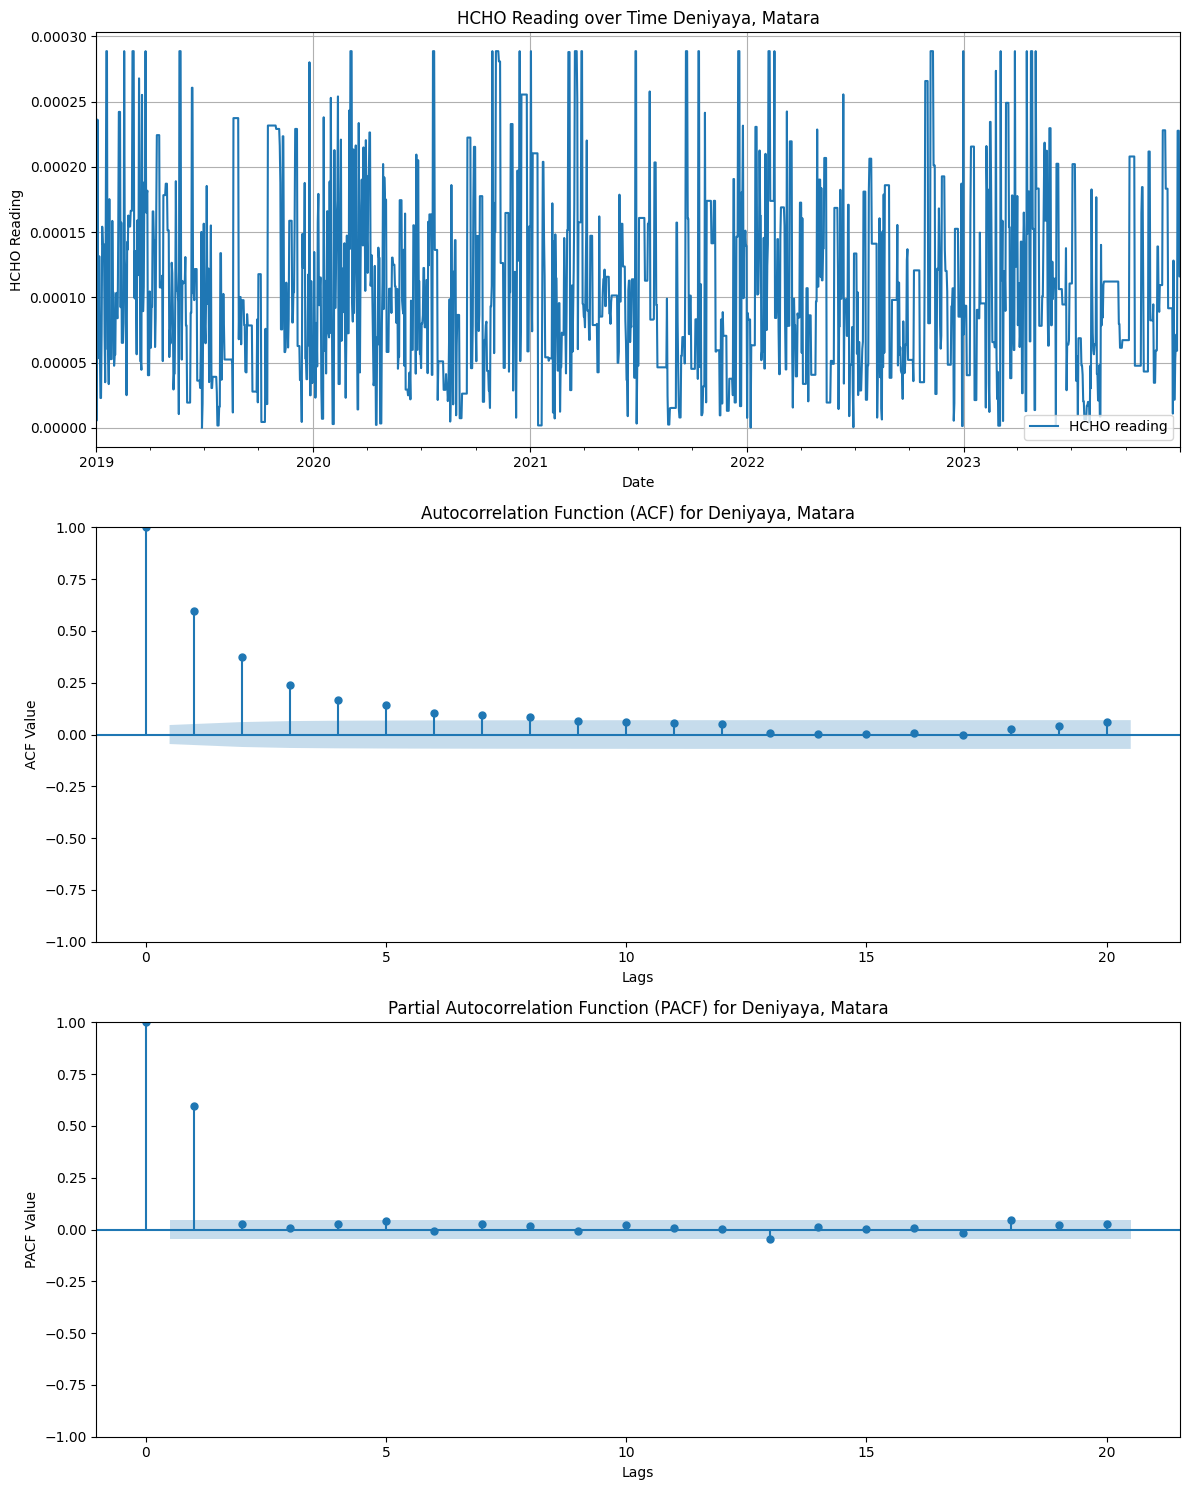



ADF Test Results Deniyaya, Matara, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -18.615577558696852
P-Value: 0.0
Number of lags: 1
Number of observations: 1824
Critical Values: {'1%': -3.9637418891719958, '5%': -3.4128997410008655, '10%': -3.1284687272976233}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [8]:
location_name = "Deniyaya, Matara"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

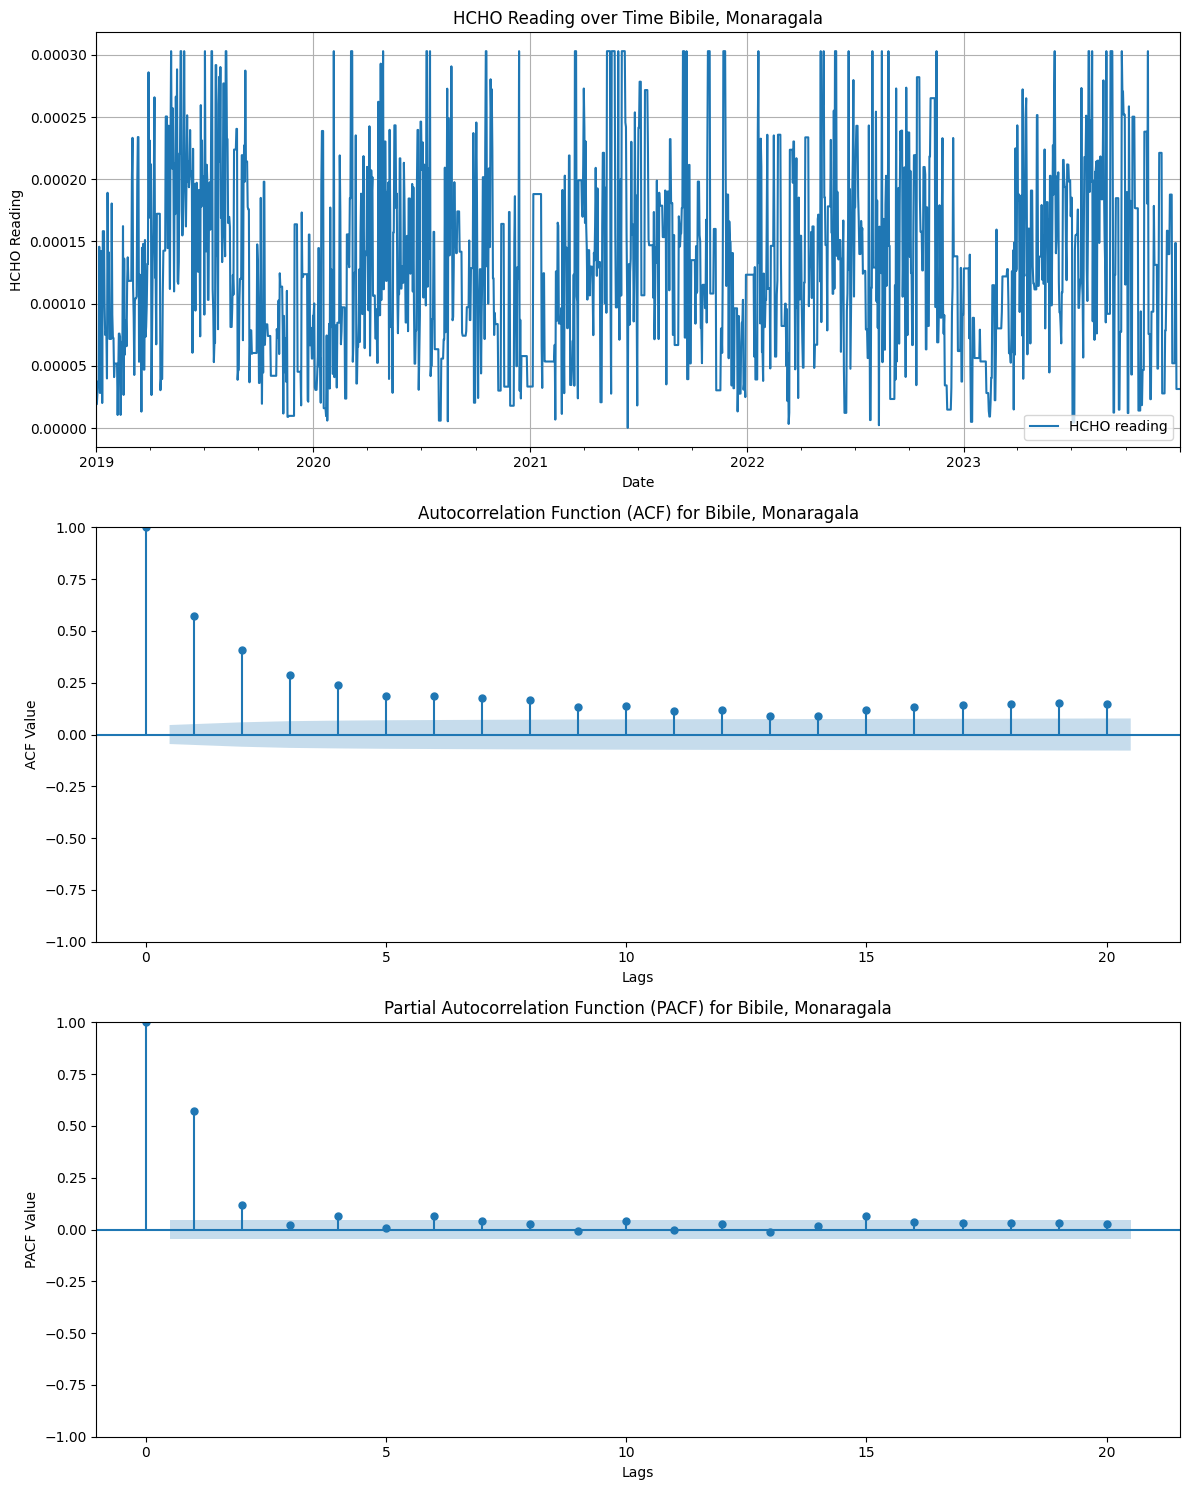



ADF Test Results Bibile, Monaragala, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -10.866678783037438
P-Value: 4.008964681240966e-17
Number of lags: 6
Number of observations: 1819
Critical Values: {'1%': -3.9637555793912167, '5%': -3.412906372335286, '10%': -3.1284726303149317}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [9]:
location_name = "Bibile, Monaragala"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

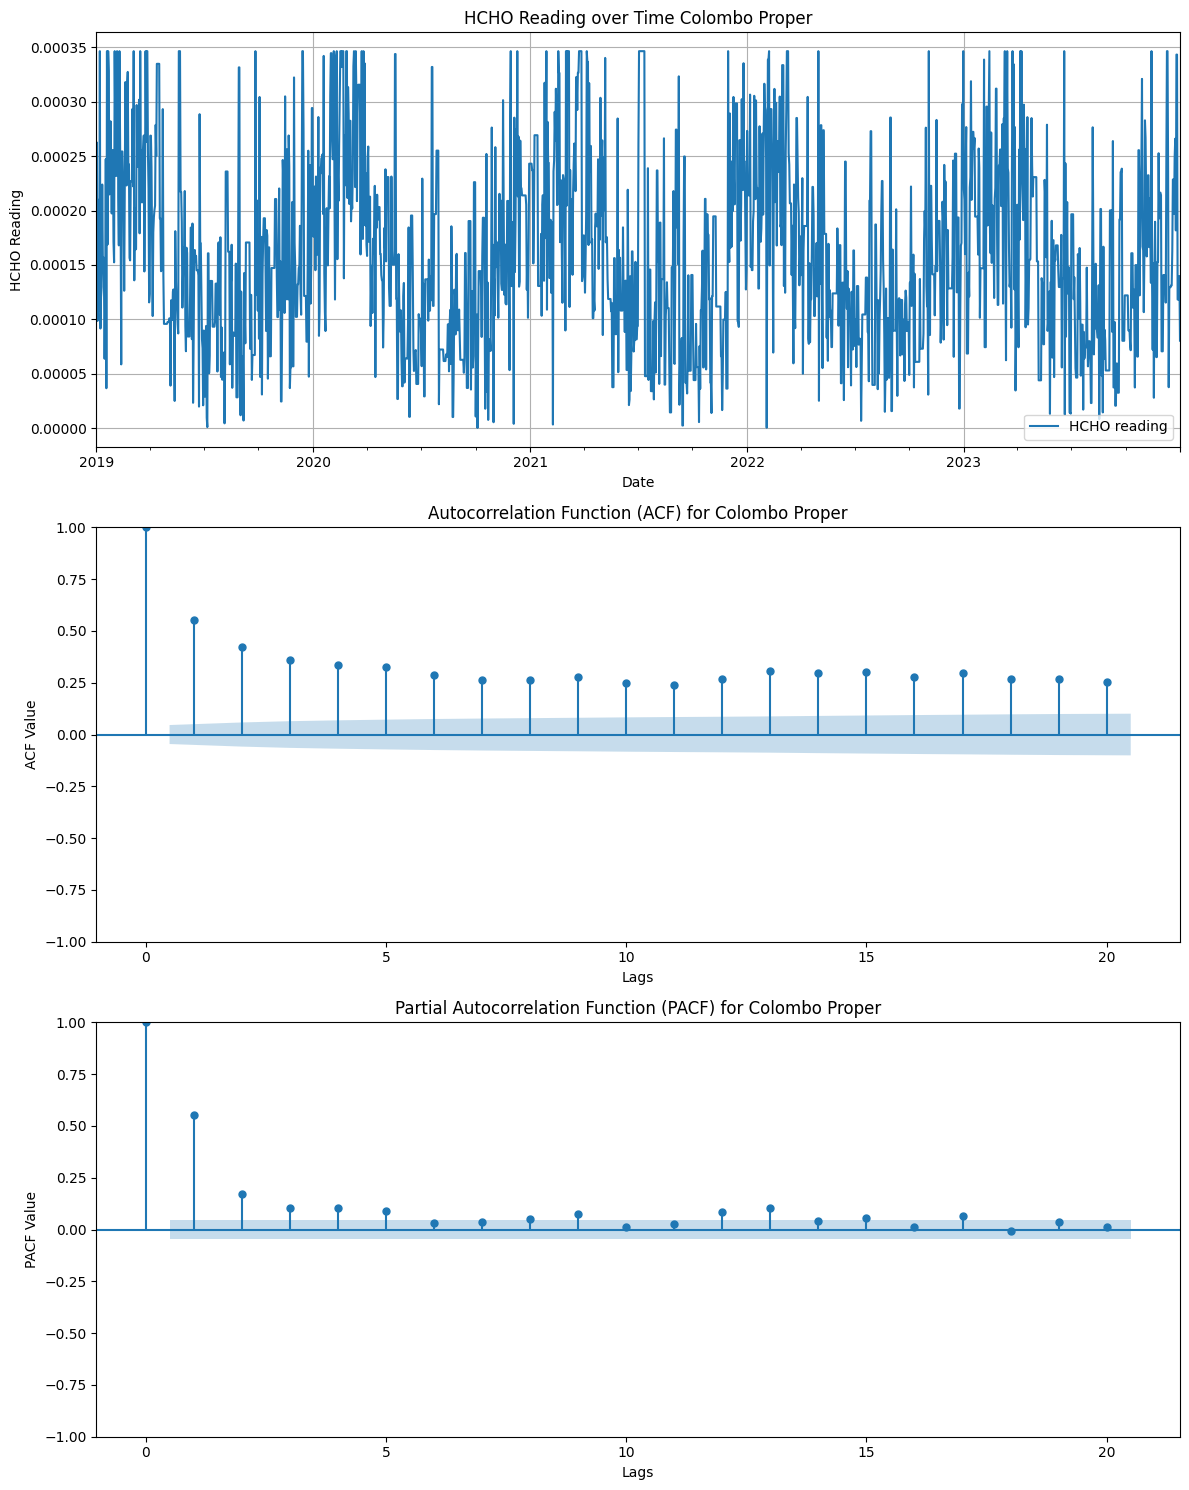



ADF Test Results Colombo Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -4.8166771448348635
P-Value: 0.00043789115270546236
Number of lags: 16
Number of observations: 1809
Critical Values: {'1%': -3.9637831872606, '5%': -3.412919745102375, '10%': -3.128480501130939}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [10]:
location_name = "Colombo Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

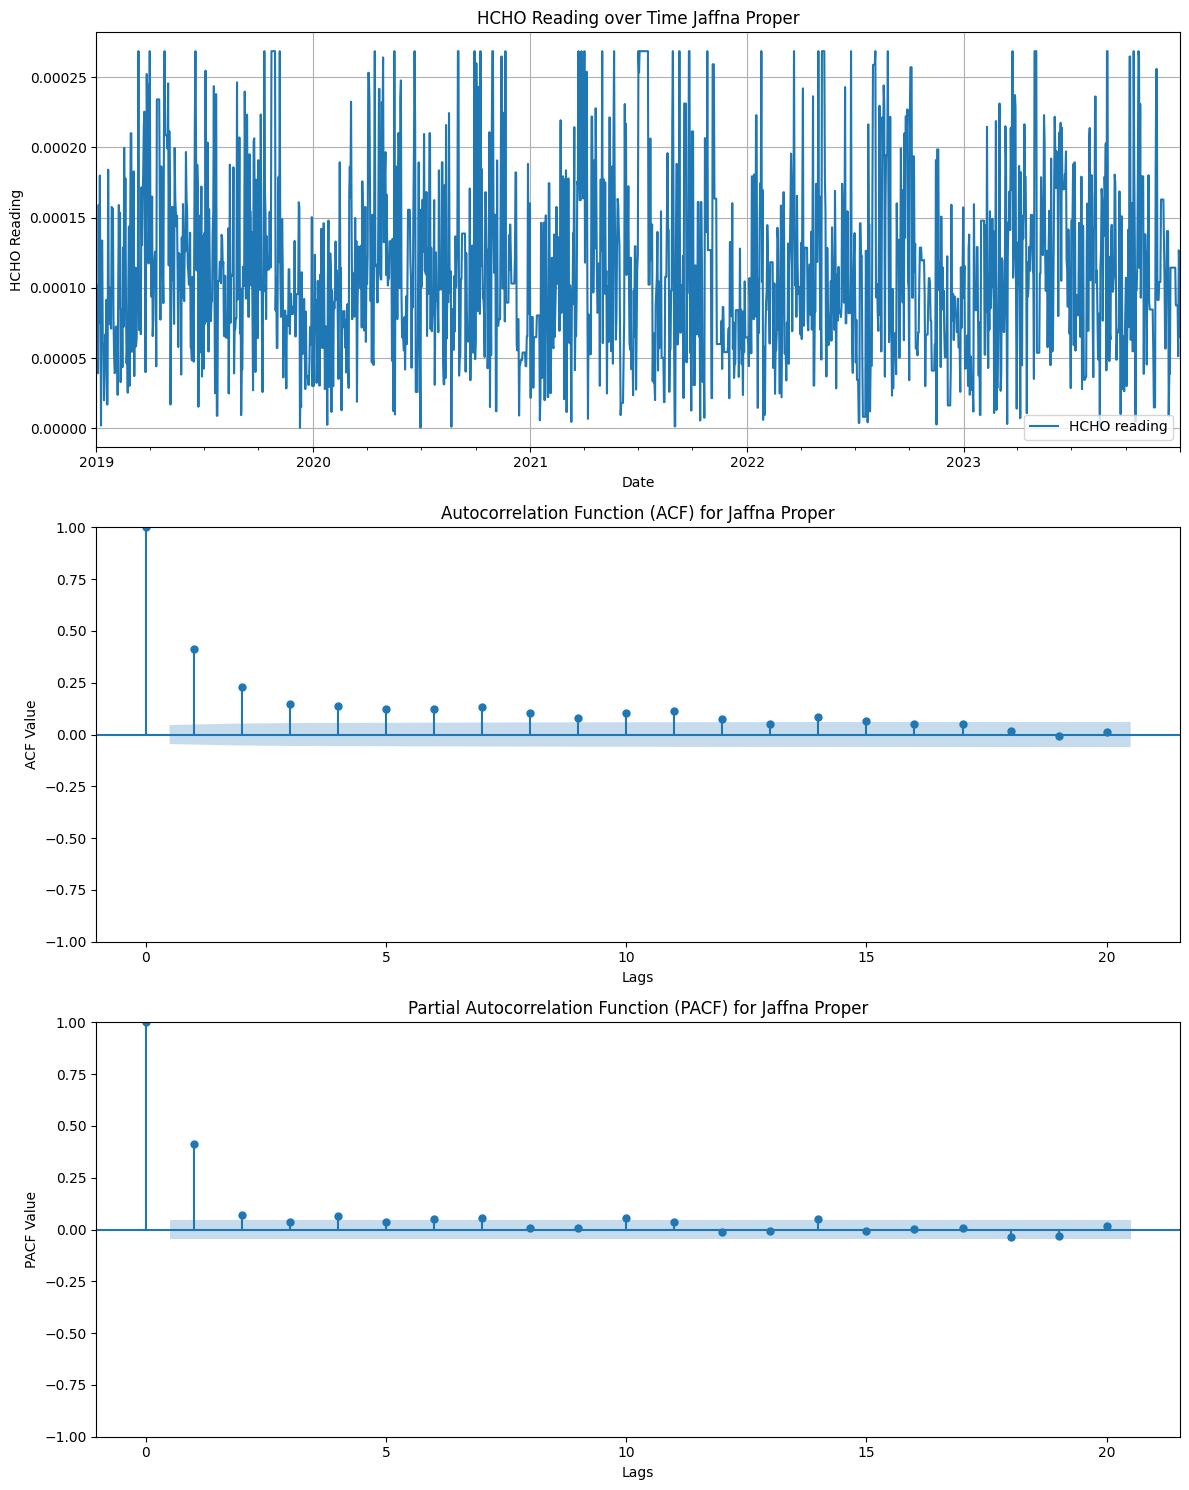



ADF Test Results Jaffna Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -11.646596568138975
P-Value: 1.495198542813012e-18
Number of lags: 6
Number of observations: 1819
Critical Values: {'1%': -3.9637555793912167, '5%': -3.412906372335286, '10%': -3.1284726303149317}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [11]:
location_name = "Jaffna Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

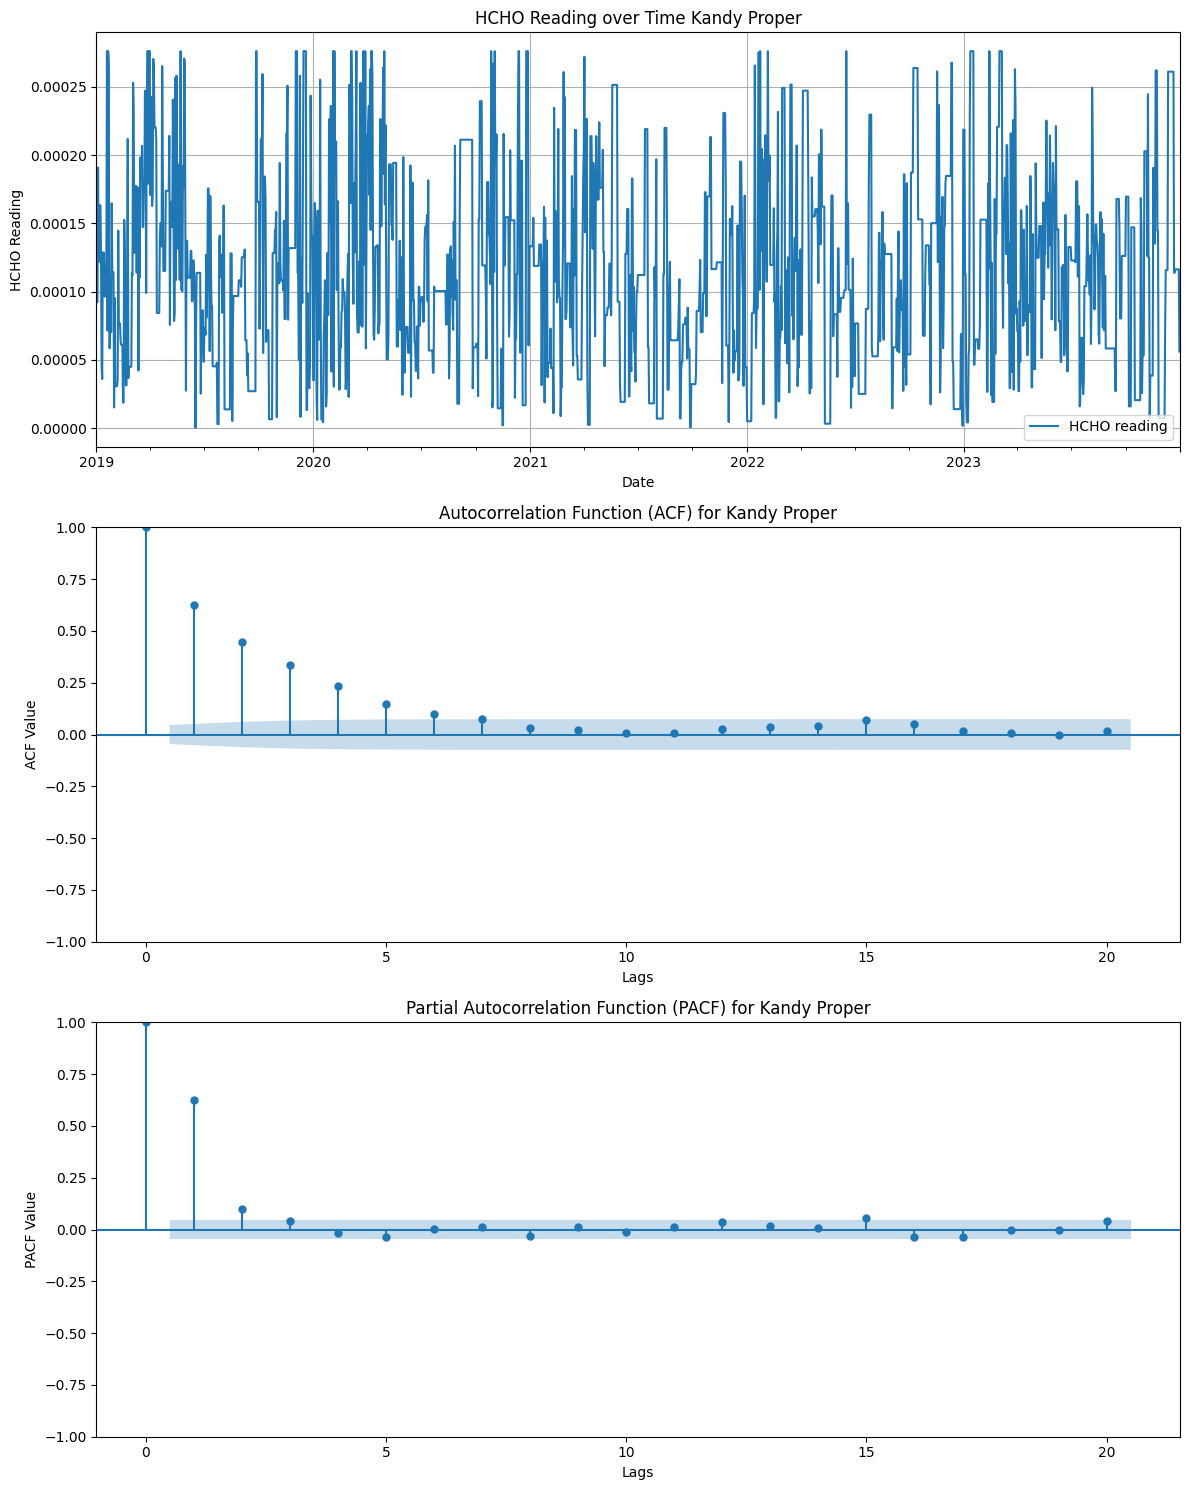



ADF Test Results Kandy Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -15.014879441705723
P-Value: 2.149578284093142e-22
Number of lags: 2
Number of observations: 1823
Critical Values: {'1%': -3.9637446211976712, '5%': -3.412901064354369, '10%': -3.128469506186859}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [12]:
location_name = "Kandy Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

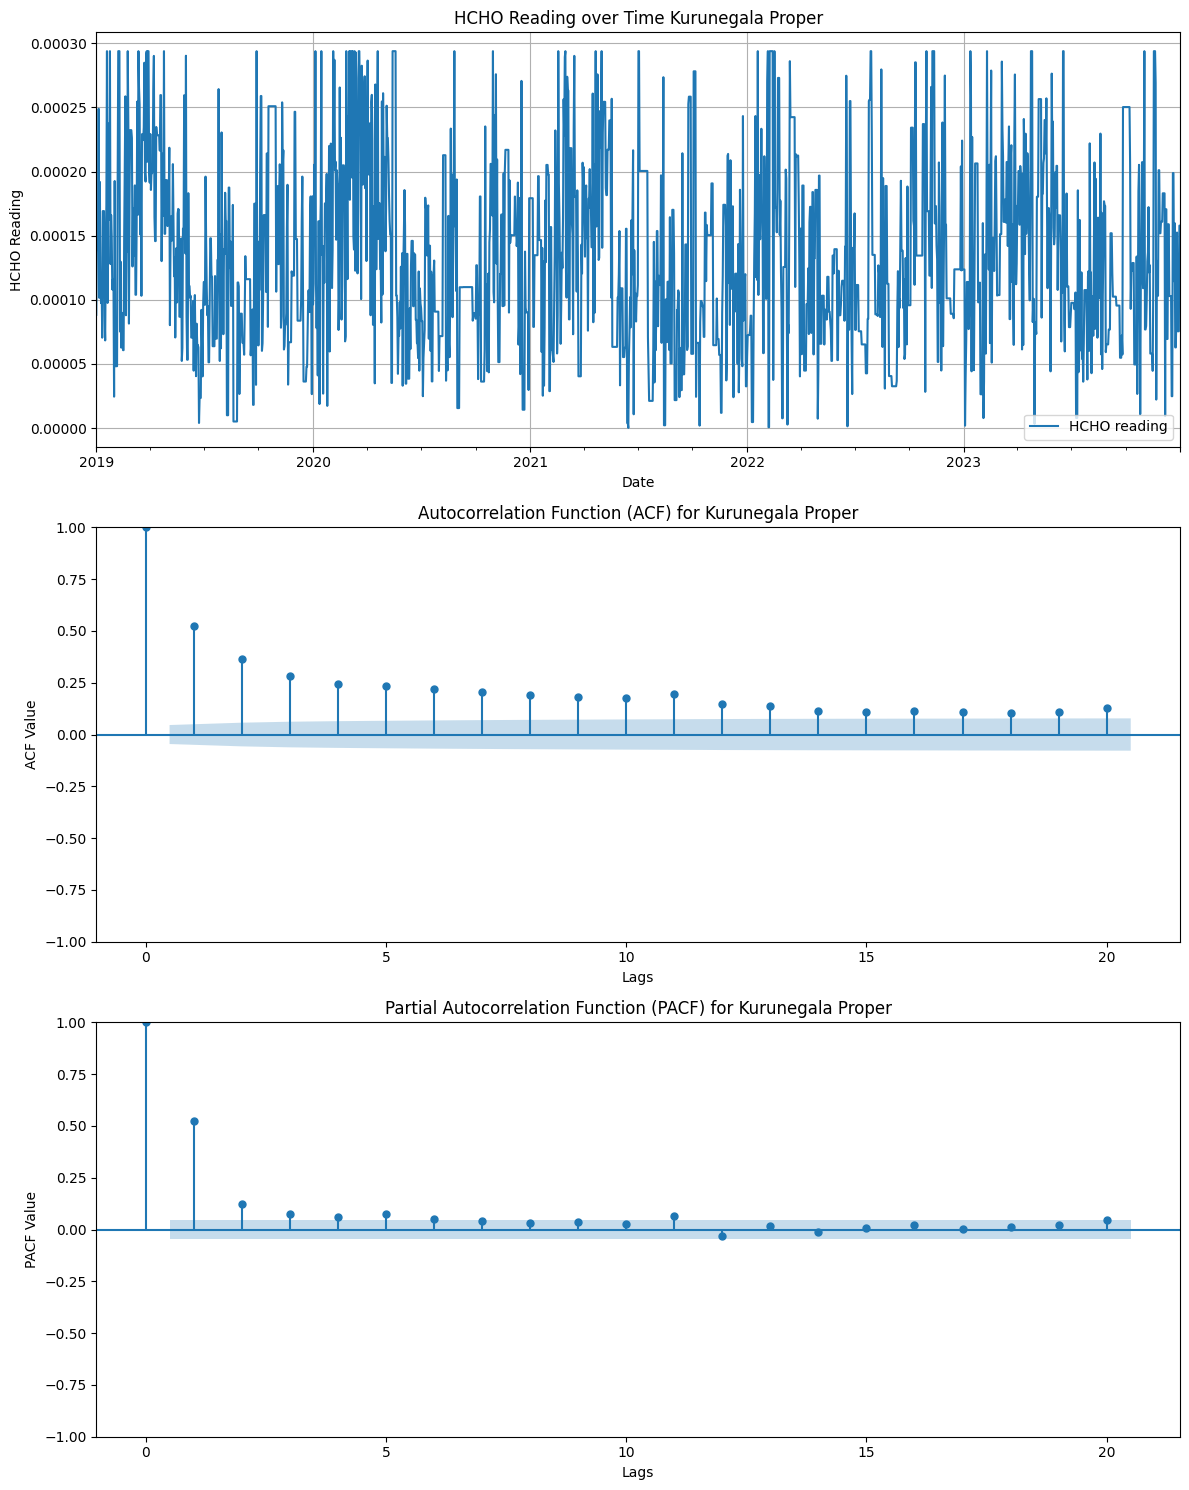



ADF Test Results Kurunegala Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -8.102084431181181
P-Value: 4.149698850713661e-11
Number of lags: 11
Number of observations: 1814
Critical Values: {'1%': -3.963769345211429, '5%': -3.412913040267851, '10%': -3.128476554866467}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [13]:
location_name = "Kurunegala Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

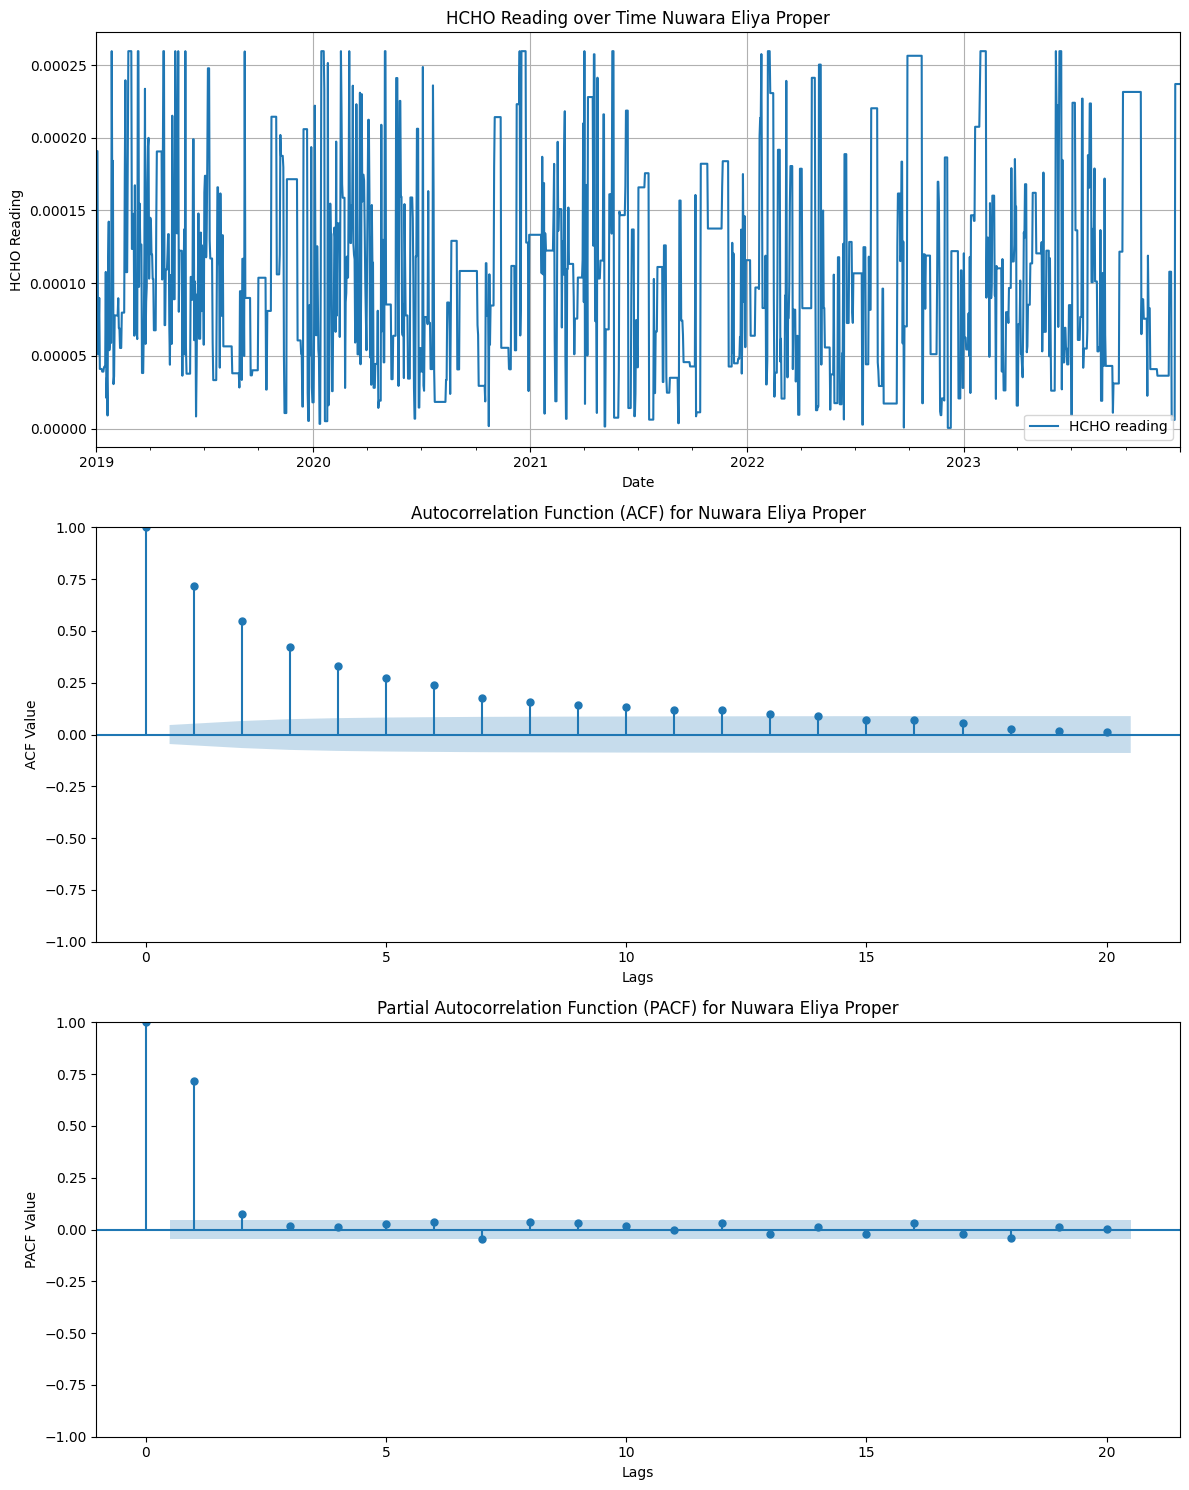



ADF Test Results Nuwara Eliya Proper, 

Null Hypothesis: The series has a unit root (non-stationary)
ADF-Statistic: -14.907510775868595
P-Value: 2.4398992740046563e-22
Number of lags: 1
Number of observations: 1824
Critical Values: {'1%': -3.9637418891719958, '5%': -3.4128997410008655, '10%': -3.1284687272976233}


Conclusion: 
Because P-value is less than 0.05 we can reject the null hypothesis and conclude that the series is stationary 




In [14]:
location_name = "Nuwara Eliya Proper"
location_data = df[df["Location"] == location_name]
acf_adf(location_data,location_name)

In [15]:
def train_arima(location_data, location_name):
    # Split the data into training and testing sets
    train, test = train_test_split(location_data, test_size=0.02, shuffle=False)

    print("Training auto_arima model")
    auto_arima_model = auto_arima(train["HCHO reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
    order = auto_arima_model.order
    seasonal_order = auto_arima_model.seasonal_order
    print("\n")
    print(f"Training ARIMA model of {location_name}")

    # Train ARIMA model of each location
    arima_model = ARIMA(train["HCHO reading"], order=order)
    arima_model = arima_model.fit()

    # Summary of the ARIMA model of each location
    print(arima_model.summary())

    # Predict the values of each location
    prediction = arima_model.get_forecast(steps=len(test))
    prediction = prediction.predicted_mean

    # Plot the predictions of ARIMA model of each location
    plt.figure(figsize=(12, 6))
    plt.plot(train.index[len(train)//2:], train["HCHO reading"].values[len(train)//2:], label="Train")
    plt.plot(test.index, test["HCHO reading"], label="Test")
    plt.plot(prediction.index, prediction, label="Predictions")
    plt.title(f"ARIMA Model for {location_name}")
    plt.xlabel("Date")
    plt.ylabel("HCHO Reading")
    plt.legend()
    plt.show()

    # Calculate the RMSE, MAE and MAPE, R2
    rmse = np.sqrt(mean_squared_error(test["HCHO reading"], prediction))
    mae = mean_absolute_error(test["HCHO reading"], prediction)
    mape = mean_absolute_percentage_error(test["HCHO reading"], prediction)
    r2 = r2_score(test["HCHO reading"], prediction)

    print("Model Evaluation")
    print("Root Mean Square Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("Mean Absolute Percentage Error:", mape)
    print("R-Square:", r2)

    return arima_model


Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29719.290, Time=21.47 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29039.773, Time=0.54 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-29147.191, Time=3.10 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29568.200, Time=8.72 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26950.139, Time=0.19 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29776.658, Time=12.24 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29795.064, Time=3.04 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-29150.518, Time=7.61 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29821.690, Time=4.82 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-29161.270, Time=3.73 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-29801.477, Time=3.13 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-29748.846, Time=9.98 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-29726.866, Time=2.24 sec
 ARIMA(1,0,1)(0,0,0)[12] interce

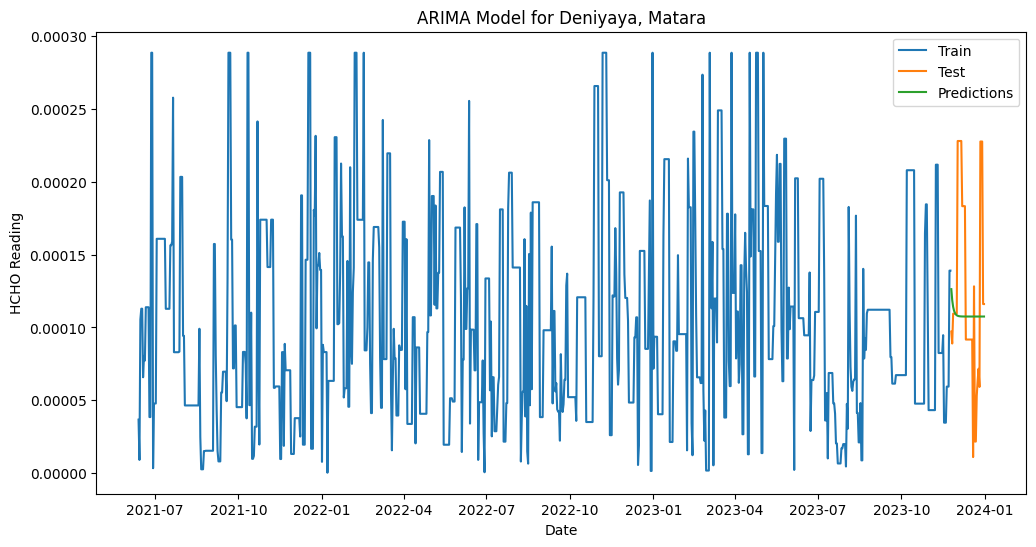

Model Evaluation
Root Mean Square Error: 6.888166419285253e-05
Mean Absolute Error: 5.26503353835066e-05
Mean Absolute Percentage Error: 0.7563173550512737
R-Square: -0.09022023853933869


In [16]:
location_name = "Deniyaya, Matara"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29501.984, Time=16.15 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-28825.896, Time=0.48 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-28742.230, Time=10.16 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29254.476, Time=8.70 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26361.368, Time=0.14 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29536.403, Time=3.86 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29540.417, Time=4.57 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-28748.053, Time=14.96 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29536.997, Time=4.63 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-29539.240, Time=4.52 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=-29542.616, Time=6.17 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=-28730.714, Time=17.96 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=-29537.960, Time=16.00 sec
 ARIMA(3,0,2)(1,0,1)[12] inte

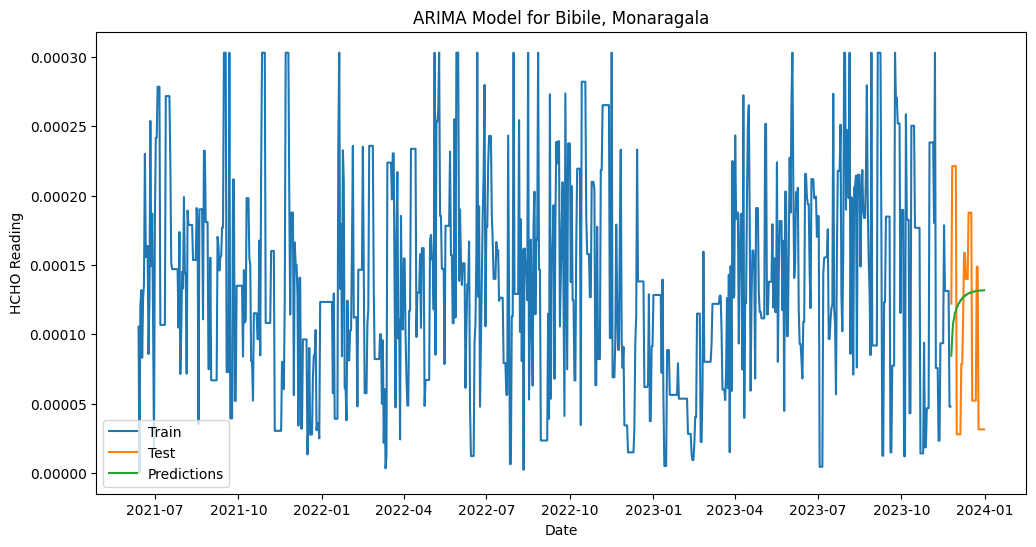

Model Evaluation
Root Mean Square Error: 7.882274224671269e-05
Mean Absolute Error: 7.109585137828104e-05
Mean Absolute Percentage Error: 1.4327192237930912
R-Square: -0.20006181759180297


In [17]:
location_name = "Bibile, Monaragala"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-29133.024, Time=8.01 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-28602.359, Time=0.68 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-28849.464, Time=2.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-29013.561, Time=7.10 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-28604.469, Time=0.65 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-29134.969, Time=4.40 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-29137.447, Time=1.33 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-29136.858, Time=3.50 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-29107.074, Time=1.17 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-29131.093, Time=1.16 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-29131.070, Time=2.55 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-29131.510, Time=11.21 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-29097.033, Time=15.34 sec
 ARIMA(1,1,3)(0,0,0)[12] interce

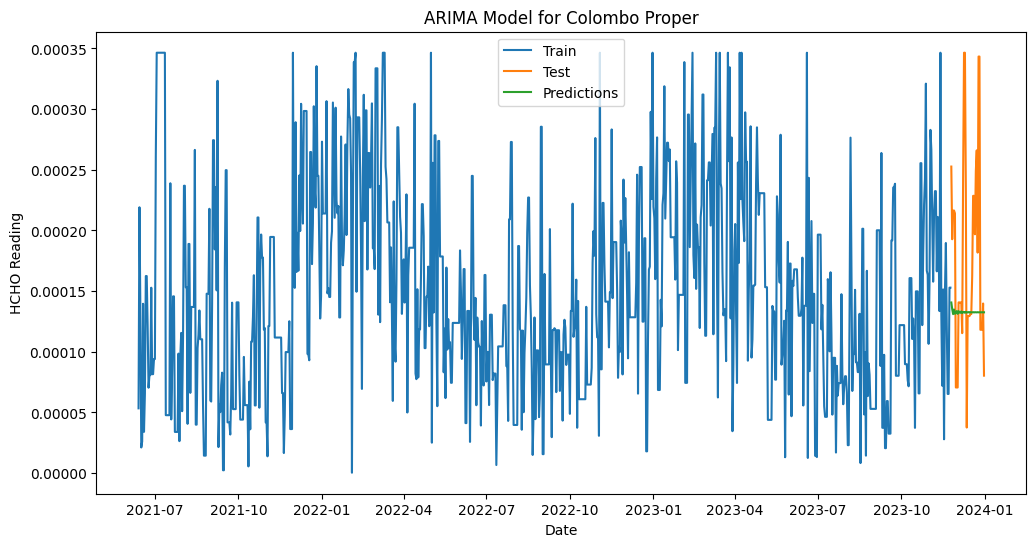

Model Evaluation
Root Mean Square Error: 9.32248613639987e-05
Mean Absolute Error: 6.785987607104689e-05
Mean Absolute Percentage Error: 0.3924747416395375
R-Square: -0.3148316393053394


In [18]:
location_name = "Colombo Proper"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29501.036, Time=97.80 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29424.523, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-28946.450, Time=6.15 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29655.503, Time=5.21 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26932.755, Time=0.14 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-29658.344, Time=1.84 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-28923.257, Time=5.63 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-29395.550, Time=10.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-29762.119, Time=3.12 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-28938.792, Time=5.04 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-29744.580, Time=8.82 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-29366.372, Time=74.58 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-29757.469, Time=4.05 sec
 ARIMA(2,0,1)(0,0,0)[12] interc

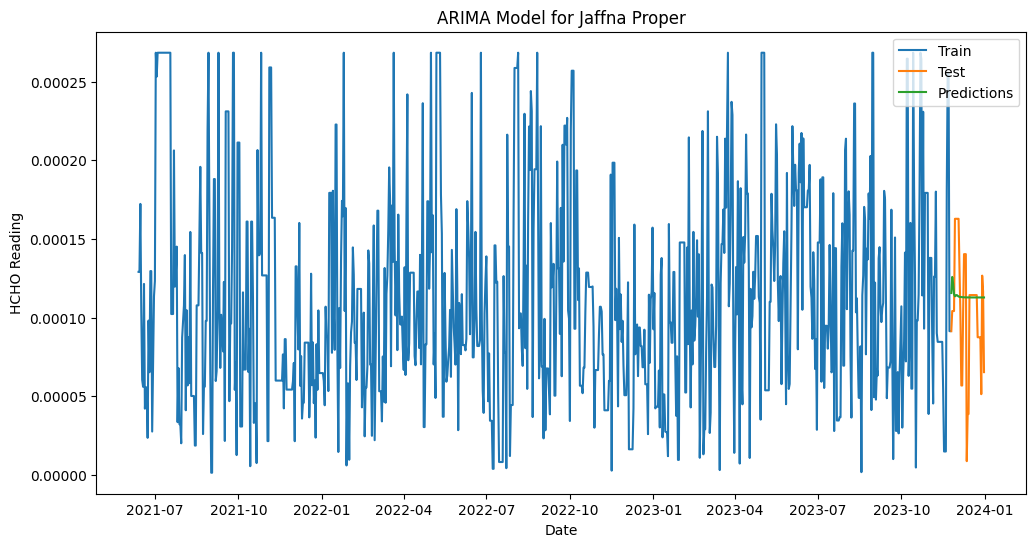

Model Evaluation
Root Mean Square Error: 3.7909319356393895e-05
Mean Absolute Error: 2.8240880849589467e-05
Mean Absolute Percentage Error: 0.6510068661986897
R-Square: -0.04179360510826169


In [19]:
location_name = "Jaffna Proper"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29938.496, Time=20.68 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29126.337, Time=0.38 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-29184.334, Time=10.42 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29641.671, Time=8.69 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26782.320, Time=0.22 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29964.310, Time=9.31 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29971.815, Time=2.27 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-29180.879, Time=14.69 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29977.335, Time=4.75 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-29198.291, Time=3.89 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-29971.076, Time=11.59 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-29851.427, Time=6.60 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-29781.305, Time=1.00 sec
 ARIMA(1,0,1)(0,0,0)[12] inter

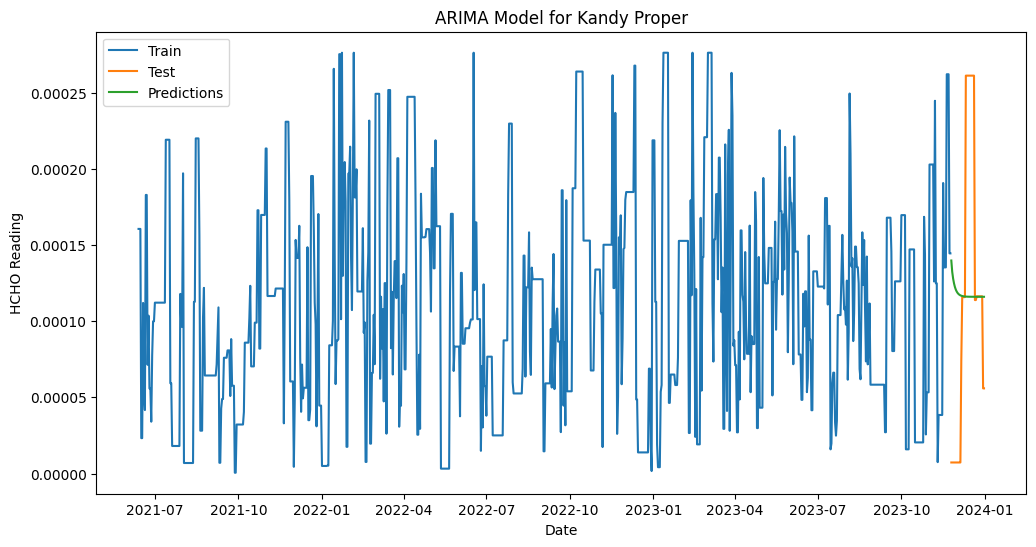

Model Evaluation
Root Mean Square Error: 9.97896729142944e-05
Mean Absolute Error: 7.836913902544928e-05
Mean Absolute Percentage Error: 4.966157684853867
R-Square: -0.05439916342075368


In [20]:
location_name = "Kandy Proper"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29538.076, Time=13.97 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29018.405, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-28699.550, Time=4.91 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29378.611, Time=6.73 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26321.173, Time=0.14 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29597.399, Time=12.38 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29618.228, Time=3.42 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-28743.608, Time=9.63 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29628.709, Time=2.46 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-28746.082, Time=6.96 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-29605.297, Time=7.60 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-29498.823, Time=11.43 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-29488.138, Time=2.67 sec
 ARIMA(1,0,1)(0,0,0)[12] interc

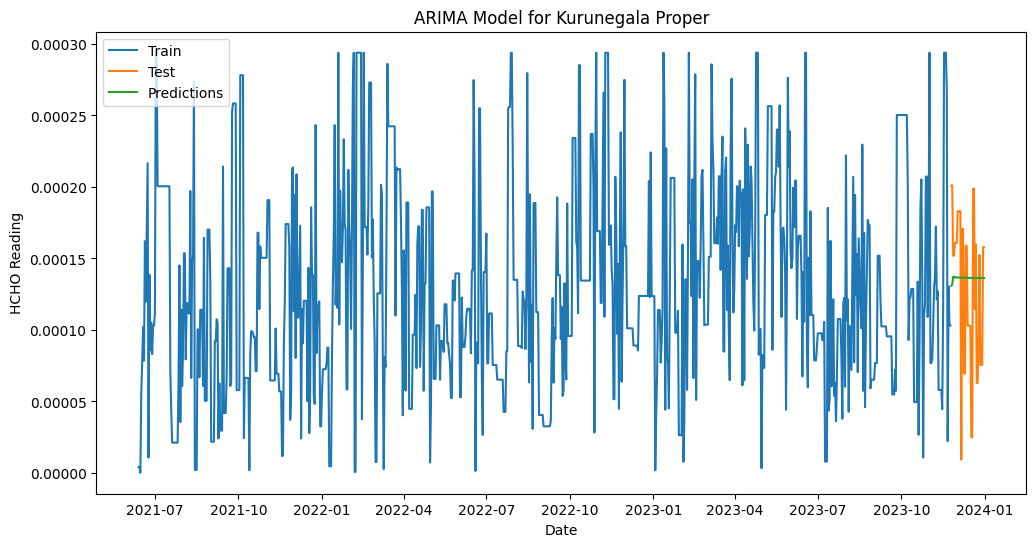

Model Evaluation
Root Mean Square Error: 5.505713529969998e-05
Mean Absolute Error: 4.757096546787285e-05
Mean Absolute Percentage Error: 0.9576305380362566
R-Square: -0.029566399910216035


In [21]:
location_name = "Kurunegala Proper"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-30176.770, Time=11.10 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29130.554, Time=0.31 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-29689.523, Time=4.27 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29844.791, Time=4.80 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26984.685, Time=0.22 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-30339.777, Time=3.93 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-30382.104, Time=3.10 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-29693.208, Time=8.35 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-30387.223, Time=3.37 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-29693.396, Time=6.69 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-30343.402, Time=3.88 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-30198.328, Time=8.94 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-30089.415, Time=2.13 sec
 ARIMA(1,0,1)(0,0,0)[12] intercep

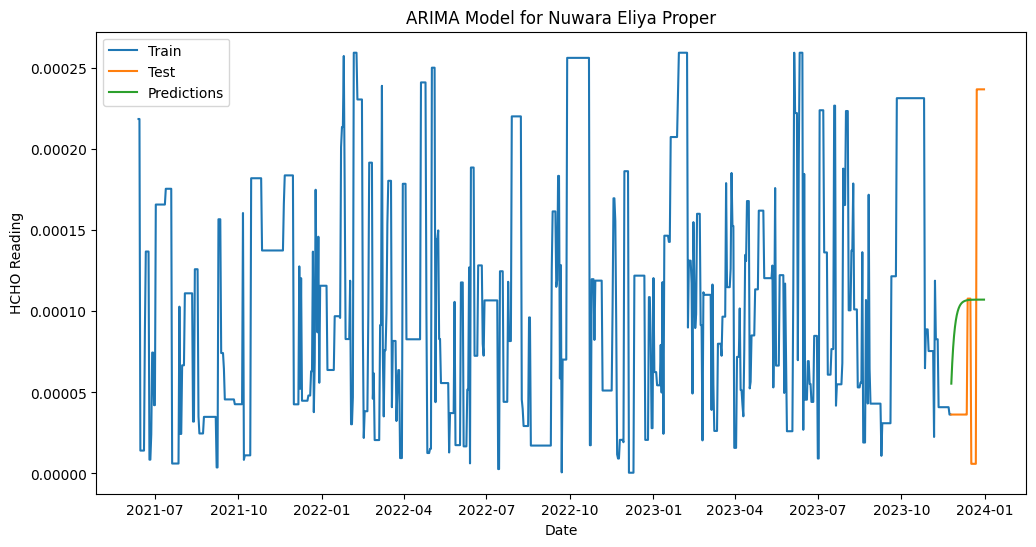

Model Evaluation
Root Mean Square Error: 8.697598241339927e-05
Mean Absolute Error: 7.686486235714002e-05
Mean Absolute Percentage Error: 3.695279973455355
R-Square: 0.034247821738711326


In [22]:
location_name = "Nuwara Eliya Proper"
location_data = df[df["Location"] == location_name]

train_arima(location_data, location_name)

In [23]:
def train_sarima(location_data, location_name):
    # Split the data into training and testing sets
    train, test = train_test_split(location_data, test_size=0.02, shuffle=False)

    print("Training auto_arima model")
    auto_arima_model = auto_arima(train["HCHO reading"], seasonal=True, m=12, stepwise=True, suppress_warnings=True, trace=True)
    order = auto_arima_model.order
    seasonal_order = auto_arima_model.seasonal_order
    print("\n")
    print(f"Training ARIMA model of {location_name}")

    # Train SARIMA model of each location
    sarima_model = SARIMAX(train["HCHO reading"], order=order, seasonal_order=seasonal_order)
    sarima_model = sarima_model.fit()

    # Summary of the SARIMA model of each location
    print(sarima_model.summary())

    # Predict the values of each location
    prediction = sarima_model.get_forecast(steps=len(test))
    prediction = prediction.predicted_mean

    # Plot the predictions of ARIMA model of each location
    plt.figure(figsize=(12, 6))
    plt.plot(train.index[len(train)//2:], train["HCHO reading"].values[len(train)//2:], label="Train")
    plt.plot(test.index, test["HCHO reading"], label="Test")
    plt.plot(prediction.index, prediction, label="Predictions")
    plt.title(f"SARIMA Model for {location_name}")
    plt.xlabel("Date")
    plt.ylabel("HCHO Reading")
    plt.legend()
    plt.show()

    # Calculate the RMSE, MAE and MAPE, R2
    rmse = np.sqrt(mean_squared_error(test["HCHO reading"], prediction))
    mae = mean_absolute_error(test["HCHO reading"], prediction)
    mape = mean_absolute_percentage_error(test["HCHO reading"], prediction)
    r2 = r2_score(test["HCHO reading"], prediction)

    print("Model Evaluation")
    print("Root Mean Square Error:", rmse)
    print("Mean Absolute Error:", mae)
    print("Mean Absolute Percentage Error:", mape)
    print("R-Square:", r2)

    return sarima_model


Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29719.290, Time=11.08 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29039.773, Time=0.31 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-29147.191, Time=2.21 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29568.200, Time=6.86 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26950.139, Time=0.13 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29776.658, Time=7.87 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29795.064, Time=4.18 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-29150.518, Time=7.53 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29821.690, Time=4.44 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-29161.270, Time=4.14 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-29801.477, Time=3.05 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-29748.846, Time=9.99 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-29726.866, Time=2.23 sec
 ARIMA(1,0,1)(0,0,0)[12] intercep

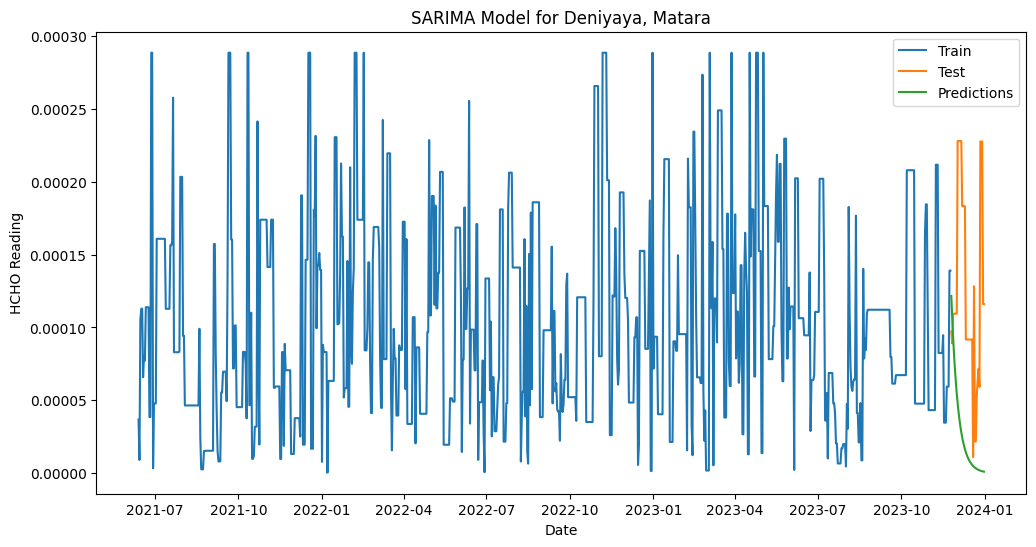

Model Evaluation
Root Mean Square Error: 0.00012323091034094667
Mean Absolute Error: 0.0001028010199882625
Mean Absolute Percentage Error: 0.7850141023879671
R-Square: -2.489364119439287


In [24]:
location_name = "Deniyaya, Matara"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29501.984, Time=12.40 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-28825.896, Time=0.30 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-28742.230, Time=4.50 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29254.476, Time=6.89 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26361.368, Time=0.14 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29536.403, Time=3.55 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29540.417, Time=3.13 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-28748.053, Time=9.20 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29536.997, Time=2.67 sec
 ARIMA(2,0,1)(0,0,0)[12] intercept   : AIC=-29539.240, Time=2.93 sec
 ARIMA(3,0,2)(0,0,0)[12] intercept   : AIC=-29542.616, Time=4.96 sec
 ARIMA(3,0,2)(1,0,0)[12] intercept   : AIC=-28730.714, Time=12.04 sec
 ARIMA(3,0,2)(0,0,1)[12] intercept   : AIC=-29537.960, Time=9.96 sec
 ARIMA(3,0,2)(1,0,1)[12] interce

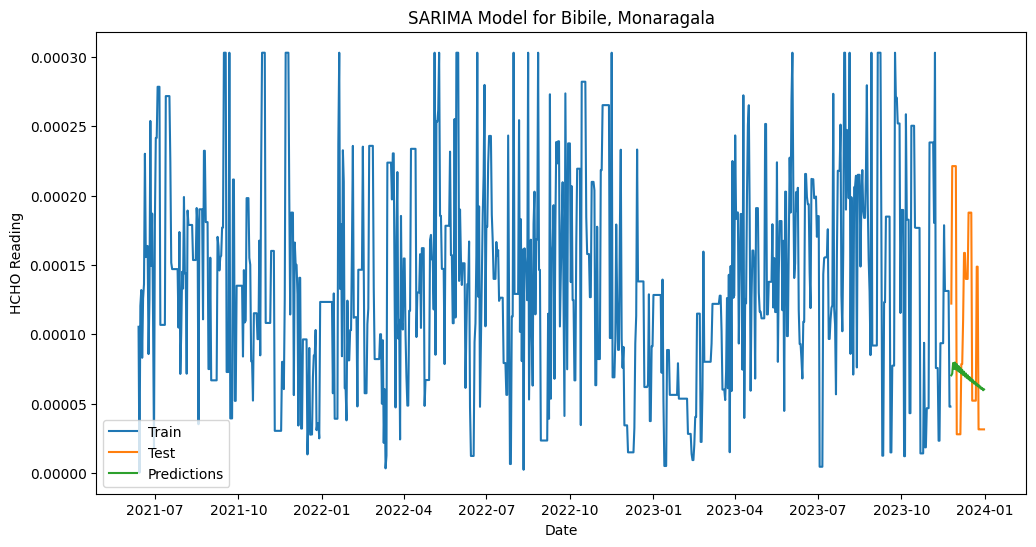

Model Evaluation
Root Mean Square Error: 7.887961133654683e-05
Mean Absolute Error: 6.419524003762711e-05
Mean Absolute Percentage Error: 0.7289802201127978
R-Square: -0.20179408522434028


In [25]:
location_name = "Bibile, Monaragala"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=-29133.024, Time=4.86 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-28602.359, Time=0.45 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-28849.464, Time=1.99 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-29013.561, Time=7.08 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-28604.469, Time=0.39 sec
 ARIMA(2,1,2)(0,0,1)[12] intercept   : AIC=-29134.969, Time=4.60 sec
 ARIMA(2,1,2)(0,0,0)[12] intercept   : AIC=-29137.447, Time=1.28 sec
 ARIMA(2,1,2)(1,0,0)[12] intercept   : AIC=-29136.858, Time=3.49 sec
 ARIMA(1,1,2)(0,0,0)[12] intercept   : AIC=-29107.074, Time=1.12 sec
 ARIMA(2,1,1)(0,0,0)[12] intercept   : AIC=-29131.093, Time=1.12 sec
 ARIMA(3,1,2)(0,0,0)[12] intercept   : AIC=-29131.070, Time=1.56 sec
 ARIMA(2,1,3)(0,0,0)[12] intercept   : AIC=-29131.510, Time=6.95 sec
 ARIMA(1,1,1)(0,0,0)[12] intercept   : AIC=-29097.033, Time=10.40 sec
 ARIMA(1,1,3)(0,0,0)[12] intercep

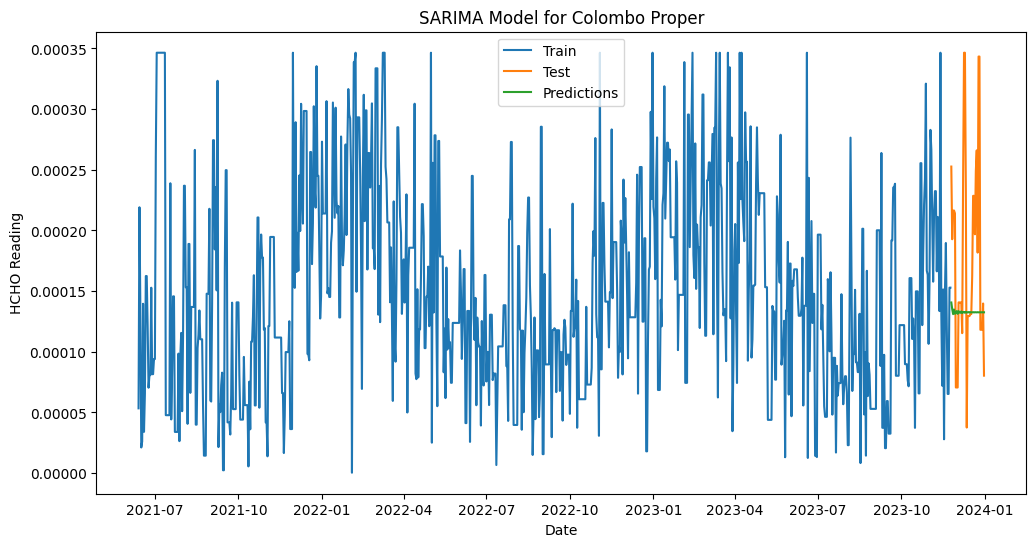

Model Evaluation
Root Mean Square Error: 9.32248613639987e-05
Mean Absolute Error: 6.785987607104689e-05
Mean Absolute Percentage Error: 0.3924747416395375
R-Square: -0.3148316393053394


In [26]:
location_name = "Colombo Proper"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29938.496, Time=11.51 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29126.337, Time=0.50 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-29184.334, Time=5.18 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29641.671, Time=5.09 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26782.320, Time=0.19 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29964.310, Time=4.89 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29971.815, Time=1.25 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-29180.879, Time=6.74 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29977.335, Time=4.94 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-29198.291, Time=3.93 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-29971.076, Time=11.58 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-29851.427, Time=6.16 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-29781.305, Time=1.93 sec
 ARIMA(1,0,1)(0,0,0)[12] interce

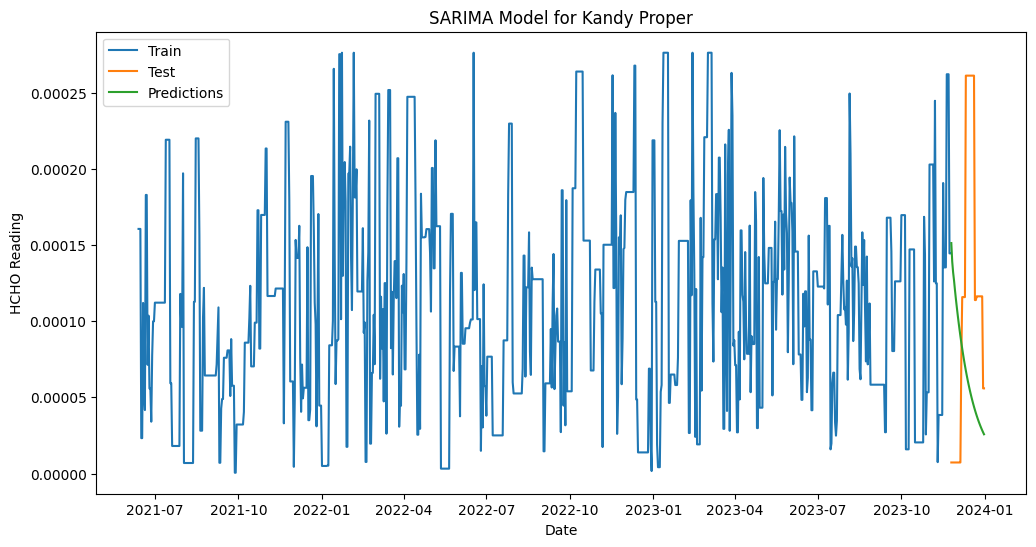

Model Evaluation
Root Mean Square Error: 0.00013032872585454694
Mean Absolute Error: 0.0001141208113252213
Mean Absolute Percentage Error: 4.9140175327658735
R-Square: -0.7985153687504927


In [27]:
location_name = "Kandy Proper"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29501.036, Time=82.54 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29424.523, Time=0.32 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-28946.450, Time=5.93 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29655.503, Time=5.33 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26932.755, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-29658.344, Time=1.79 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=-28923.257, Time=4.94 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=-29395.550, Time=10.28 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-29762.119, Time=2.91 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=-28938.792, Time=5.77 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=-29744.580, Time=8.05 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=-29366.372, Time=62.69 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-29757.469, Time=2.74 sec
 ARIMA(2,0,1)(0,0,0)[12] interc

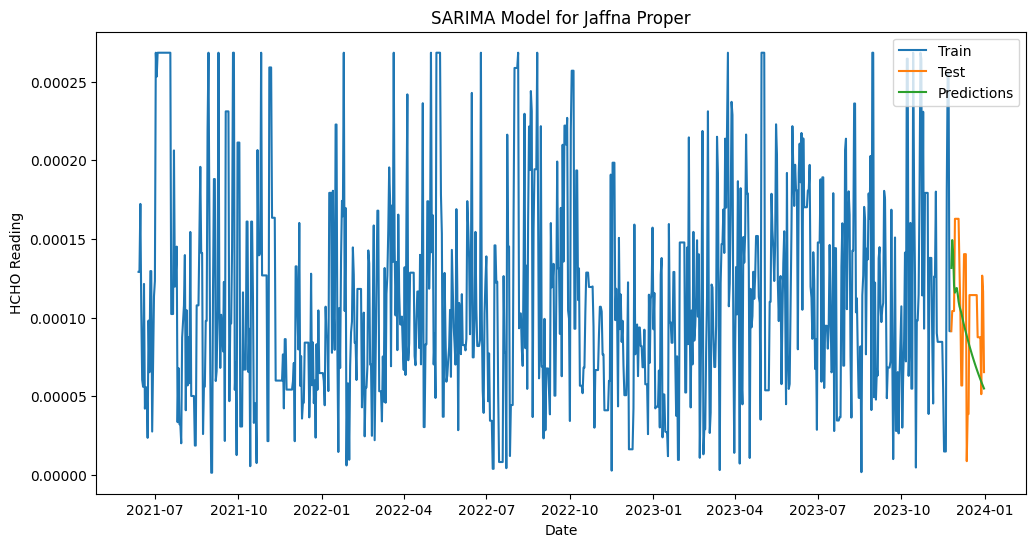

Model Evaluation
Root Mean Square Error: 4.160876854117708e-05
Mean Absolute Error: 3.826772824554005e-05
Mean Absolute Percentage Error: 0.6145308753973417
R-Square: -0.25504540630341044


In [28]:
location_name = "Jaffna Proper"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-29538.076, Time=21.81 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29018.405, Time=0.87 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-28699.550, Time=10.88 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29378.611, Time=12.75 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26321.173, Time=0.41 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-29597.399, Time=16.34 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-29618.228, Time=3.38 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-28743.608, Time=9.57 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-29628.709, Time=2.45 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-28746.082, Time=7.91 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-29605.297, Time=7.02 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-29498.823, Time=22.69 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-29488.138, Time=5.79 sec
 ARIMA(1,0,1)(0,0,0)[12] inte

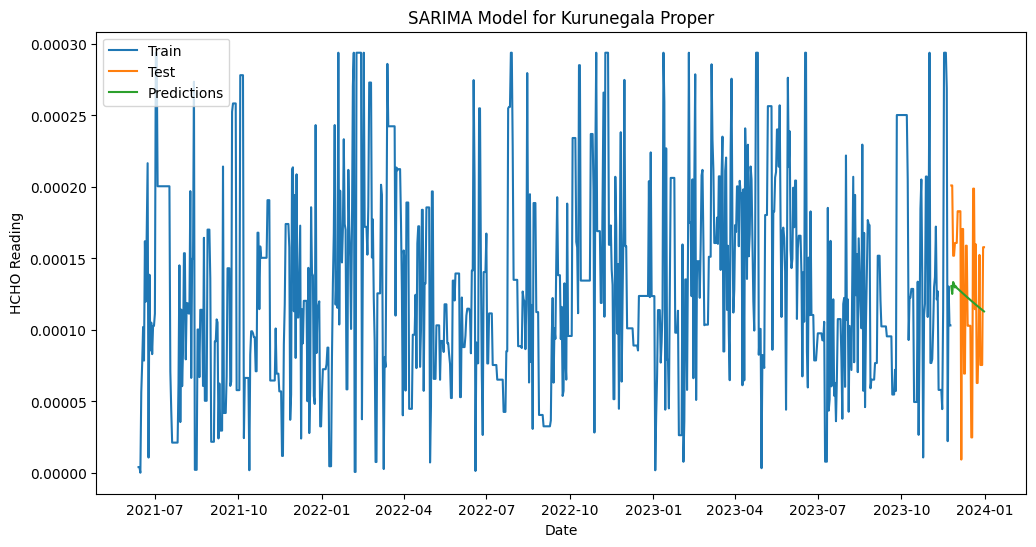

Model Evaluation
Root Mean Square Error: 5.280157977397705e-05
Mean Absolute Error: 4.6777005015867485e-05
Mean Absolute Percentage Error: 0.8565672645160631
R-Square: 0.05306324841826182


In [29]:
location_name = "Kurunegala Proper"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

Training auto_arima model
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-30176.770, Time=11.18 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-29130.554, Time=0.31 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-29689.523, Time=4.28 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-29844.791, Time=5.50 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-26984.685, Time=0.13 sec
 ARIMA(2,0,2)(0,0,1)[12] intercept   : AIC=-30339.777, Time=3.52 sec
 ARIMA(2,0,2)(0,0,0)[12] intercept   : AIC=-30382.104, Time=3.14 sec
 ARIMA(2,0,2)(1,0,0)[12] intercept   : AIC=-29693.208, Time=8.29 sec
 ARIMA(1,0,2)(0,0,0)[12] intercept   : AIC=-30387.223, Time=3.28 sec
 ARIMA(1,0,2)(1,0,0)[12] intercept   : AIC=-29693.396, Time=7.65 sec
 ARIMA(1,0,2)(0,0,1)[12] intercept   : AIC=-30343.402, Time=3.08 sec
 ARIMA(1,0,2)(1,0,1)[12] intercept   : AIC=-30198.328, Time=9.89 sec
 ARIMA(0,0,2)(0,0,0)[12] intercept   : AIC=-30089.415, Time=1.17 sec
 ARIMA(1,0,1)(0,0,0)[12] intercep

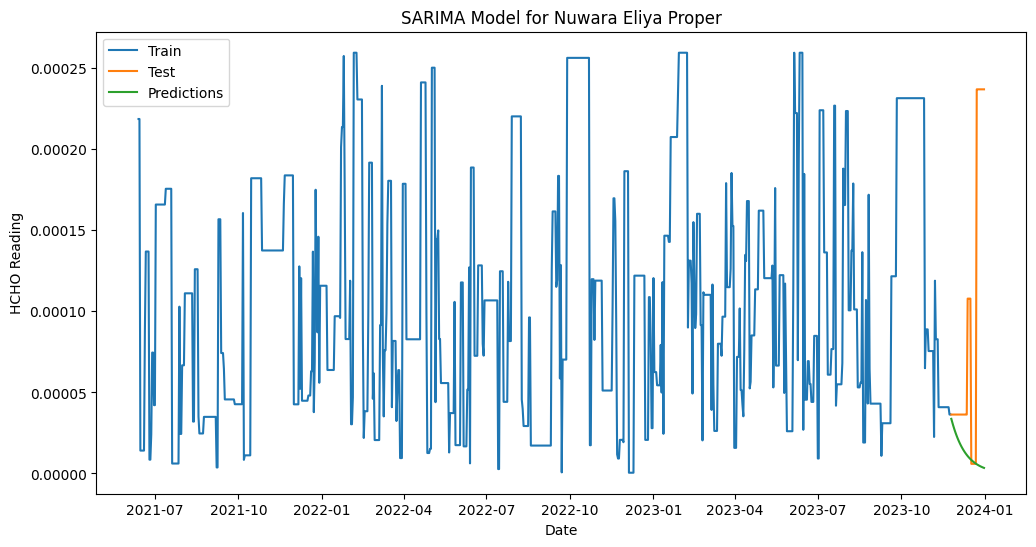

Model Evaluation
Root Mean Square Error: 0.00011972047502919782
Mean Absolute Error: 7.494862220524859e-05
Mean Absolute Percentage Error: 0.5788637921727788
R-Square: -0.8298010535589511


In [30]:
location_name = "Nuwara Eliya Proper"
location_data = df[df["Location"] == location_name]

train_sarima(location_data, location_name)

### Conclusion
Using 'auto_arima' for ARIMA and SARIMA model selection may lead to low prediction accuracy. Manually assigning parameters may help to improve forecasting performance.

## Applying Parameters for SARIMA Model Manually

In [44]:
def manually_entered_SARIMA(location_data, order, seasonal_order, location_name):
    # Split the data into training and testing sets
    train, test = train_test_split(location_data, test_size=0.02, shuffle=False)

    model = SARIMAX(train['HCHO reading'], order=order, seasonal_order=seasonal_order)
    results = model.fit()

    # print the summary of the SARIMA model
    print(results.summary())

    # Generate future forecast
    forecast_steps = len(test)
    forecast = results.get_forecast(steps=forecast_steps)

    # Extract forecasted values and confidence intervals
    forecast_values = forecast.predicted_mean.to_frame()
    confidence_intervals = forecast.conf_int()

    # plot the train, test, confidence intervals and forecast
    plt.figure(figsize=(10, 6))
    plt.plot(test.index, test['HCHO reading'], label='Test')
    plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
    plt.fill_between(test.index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='green', alpha=0.3)
    plt.title(f'SARIMAX Model Fit and Forecast for {location_name}')
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    # Calculate the RMSE, MAE and MAPE, R2
    rmse = np.sqrt(mean_squared_error(test['HCHO reading'], forecast_values['predicted_mean']))
    mae = mean_absolute_error(test['HCHO reading'], forecast_values['predicted_mean'])

    print("Model Evaluation")
    print("Root Mean Square Error: ", rmse)
    print("Mean Absolute Error: ", mae)

In [45]:
def forecast_for_month(location_data, order, seasonal_order, location_name, forecast_steps=30):

    sarima_model = SARIMAX(location_data['HCHO reading'], order=order, seasonal_order=seasonal_order)
    results = sarima_model.fit()

    # Generate future forecast
    forecast = results.get_forecast(steps=forecast_steps)

    # Extract forecasted values
    forecast_values = forecast.predicted_mean.to_frame().rename(columns={'predicted_mean': 'HCHO reading'})

    # plot the train, test, confidence intervals and forecast
    plt.figure(figsize=(10, 6))
    location_data = location_data.loc["2023-01-01":]
    plt.plot(location_data.index, location_data['HCHO reading'], label='Actual')
    plt.plot(forecast_values.index, forecast_values, color='red', label='Forecast')
    plt.title(f'SARIMAX Model Fit and Forecast for {location_name}')
    plt.xlabel('Date')
    plt.ylabel('HCHO Reading')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    return forecast_values


                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14567.274
Date:                            Sun, 21 Apr 2024   AIC                         -29124.547
Time:                                    00:18:18   BIC                         -29097.137
Sample:                                01-01-2019   HQIC                        -29114.422
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5507   3.46e-19   1.59e+18      0.000       0.551       0.551
ma.L1         -0.8171   4.75e-19  -

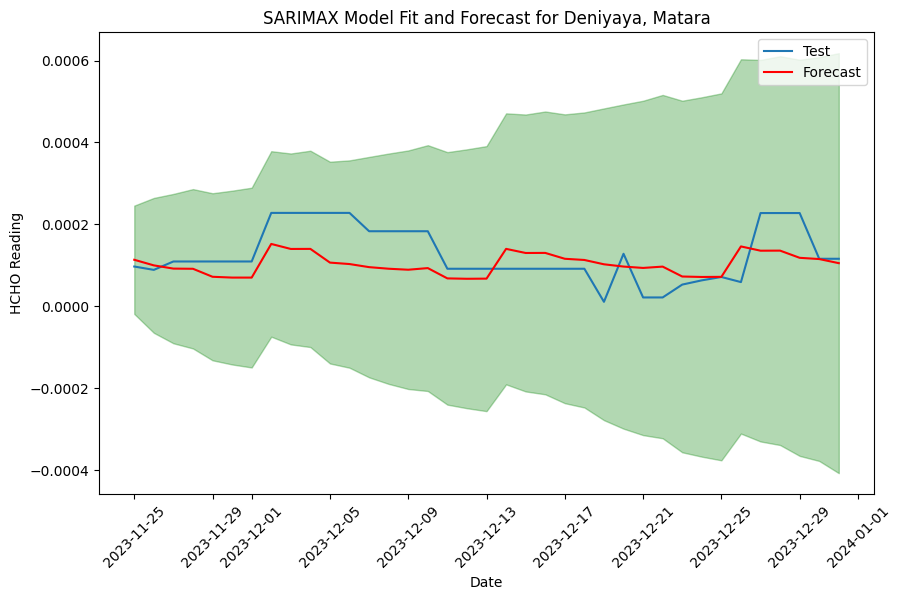

Model Evaluation
Root Mean Square Error:  6.478084790212574e-05
Mean Absolute Error:  5.331996343715171e-05


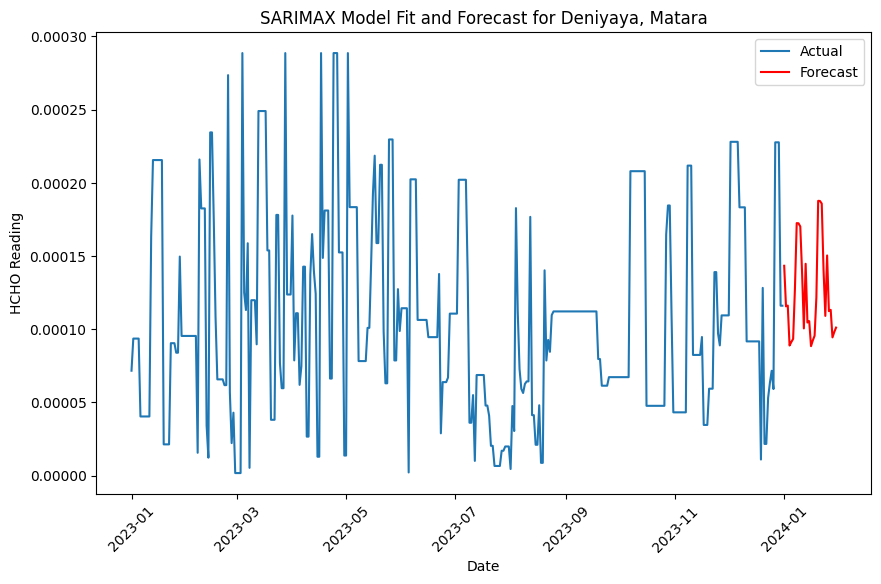

In [57]:
location_name = "Deniyaya, Matara"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
matara_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14405.530
Date:                            Sun, 21 Apr 2024   AIC                         -28801.060
Time:                                    00:18:39   BIC                         -28773.649
Sample:                                01-01-2019   HQIC                        -28790.935
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2671   5.41e-19   4.93e+17      0.000       0.267       0.267
ma.L1         -0.6289    7.6e-19  -

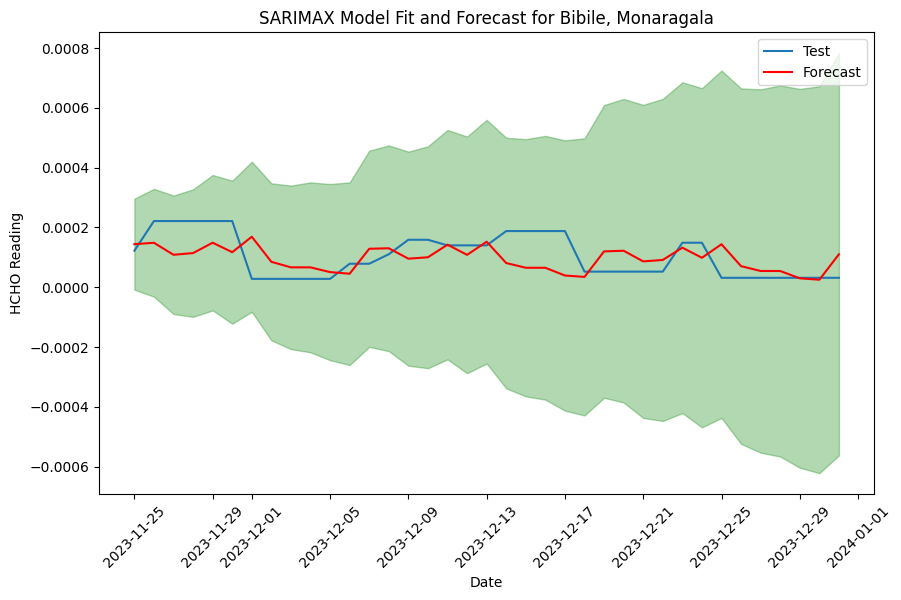

Model Evaluation
Root Mean Square Error:  7.081674318239865e-05
Mean Absolute Error:  5.7836506054444856e-05


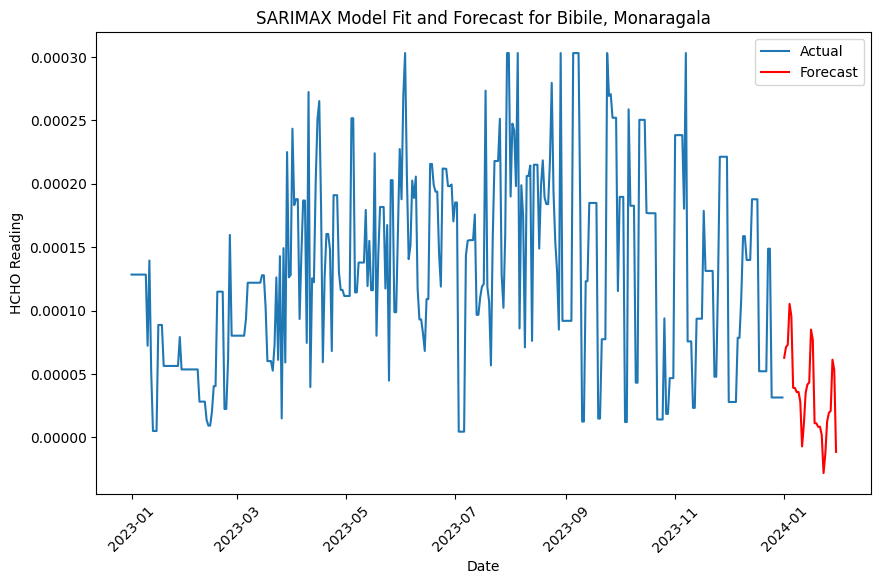

In [58]:
location_name = "Bibile, Monaragala"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
monaragala_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14198.692
Date:                            Sun, 21 Apr 2024   AIC                         -28387.385
Time:                                    00:19:05   BIC                         -28359.974
Sample:                                01-01-2019   HQIC                        -28377.260
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2478   5.24e-19   4.73e+17      0.000       0.248       0.248
ma.L1         -0.7271   8.25e-19  -

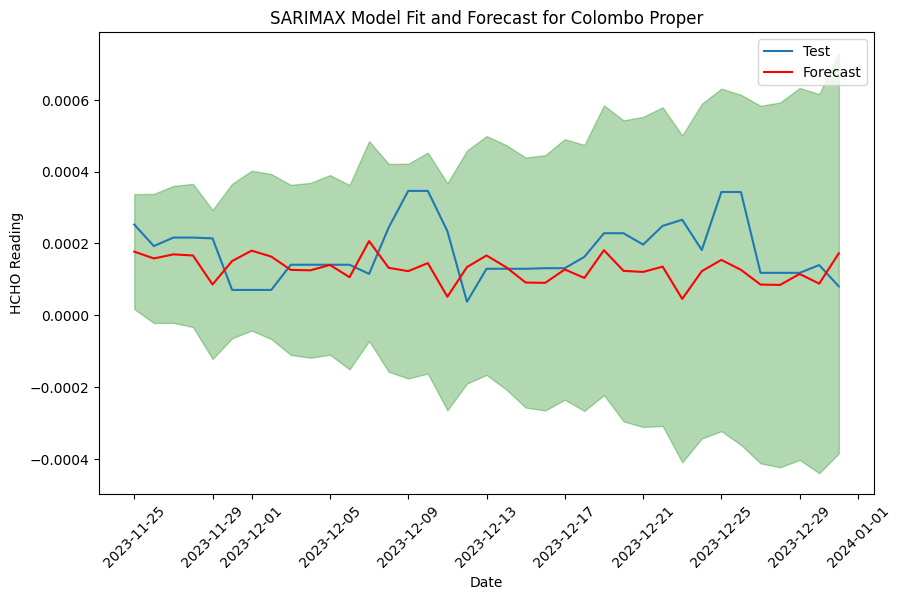

Model Evaluation
Root Mean Square Error:  0.00010384211528176426
Mean Absolute Error:  8.144957152606013e-05


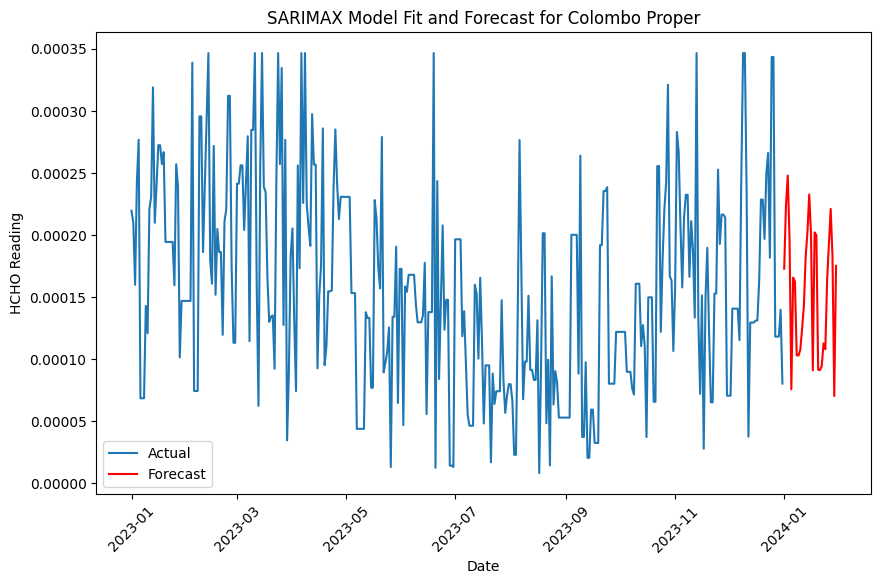

In [59]:
location_name = "Colombo Proper"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
colombo_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14591.573
Date:                            Sun, 21 Apr 2024   AIC                         -29173.145
Time:                                    00:19:16   BIC                         -29145.734
Sample:                                01-01-2019   HQIC                        -29163.020
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2905    3.9e-19   7.45e+17      0.000       0.291       0.291
ma.L1         -0.6147   5.33e-19  -

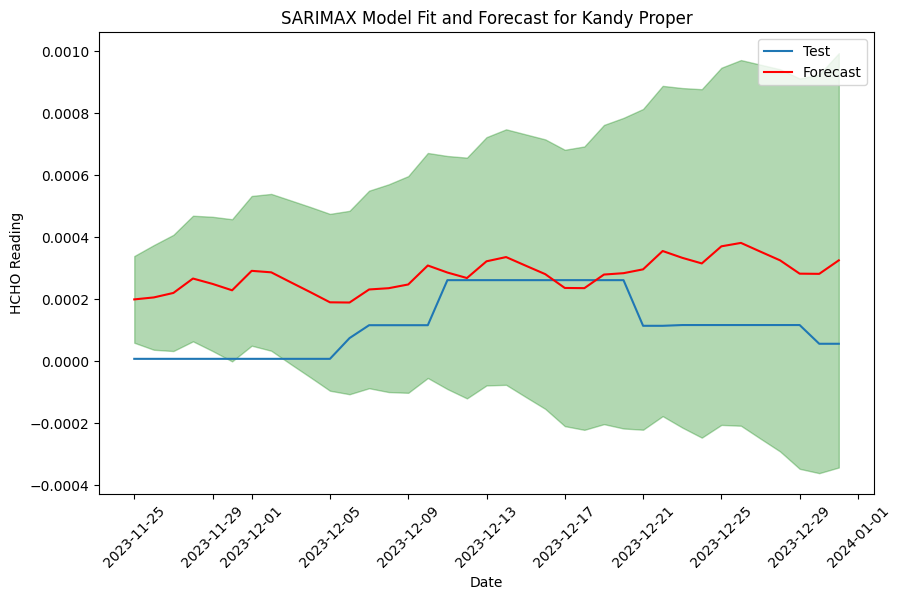

Model Evaluation
Root Mean Square Error:  0.00018506071933808036
Mean Absolute Error:  0.00016197223036606292


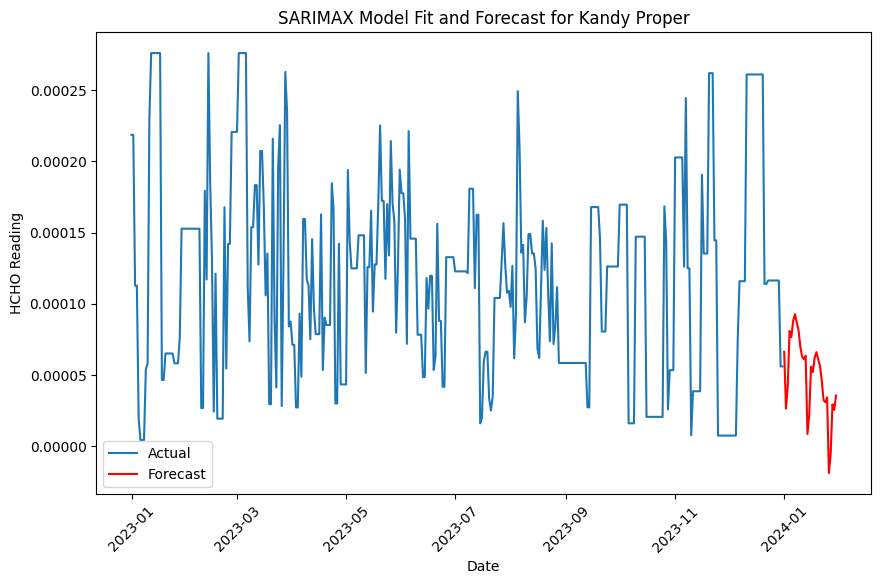

In [60]:
location_name = "Kandy Proper"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
kandy_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14489.592
Date:                            Sun, 21 Apr 2024   AIC                         -28969.184
Time:                                    00:19:27   BIC                         -28941.773
Sample:                                01-01-2019   HQIC                        -28959.059
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3514   3.87e-19   9.08e+17      0.000       0.351       0.351
ma.L1         -0.8268   6.38e-19   

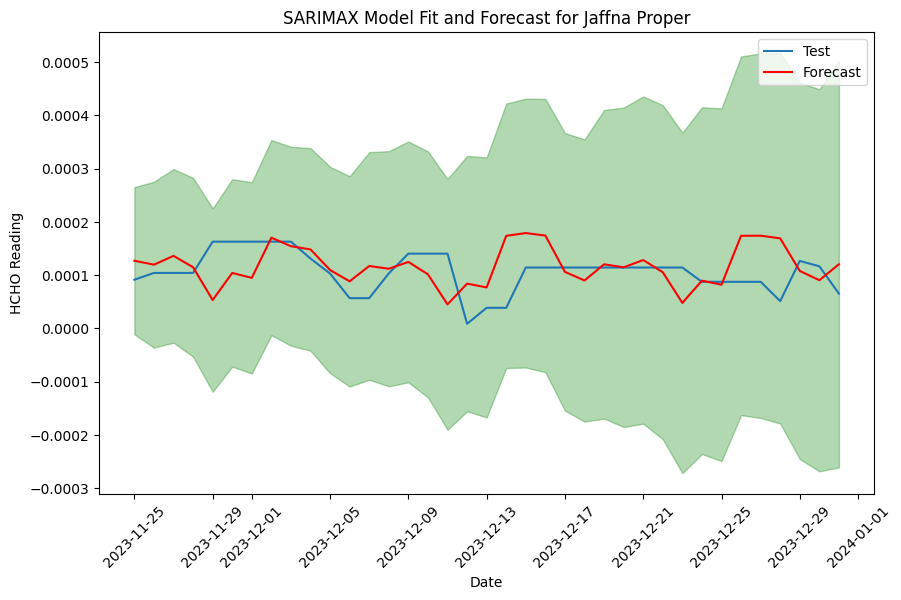

Model Evaluation
Root Mean Square Error:  5.4541312386176183e-05
Mean Absolute Error:  4.105269514670669e-05


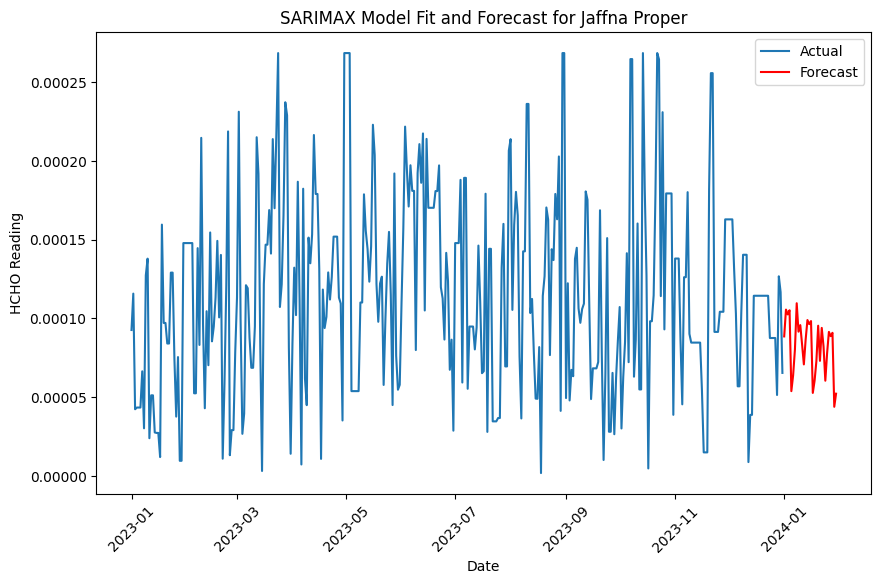

In [61]:
location_name = "Jaffna Proper"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
jaffna_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14459.583
Date:                            Sun, 21 Apr 2024   AIC                         -28909.165
Time:                                    00:19:41   BIC                         -28881.755
Sample:                                01-01-2019   HQIC                        -28899.040
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1905   3.73e-19    5.1e+17      0.000       0.190       0.190
ma.L1         -0.6664   6.52e-19  -

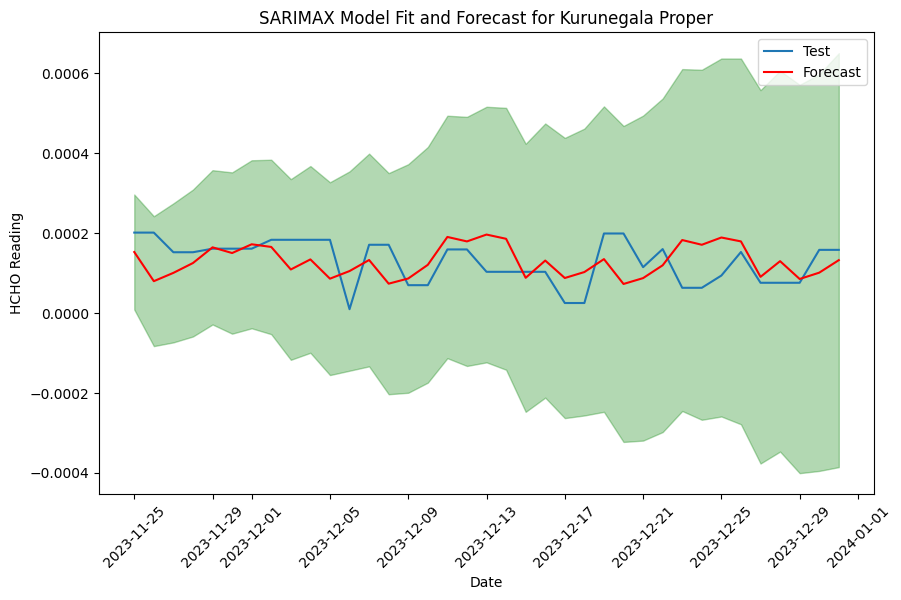

Model Evaluation
Root Mean Square Error:  6.462246697153478e-05
Mean Absolute Error:  5.3787081506293324e-05


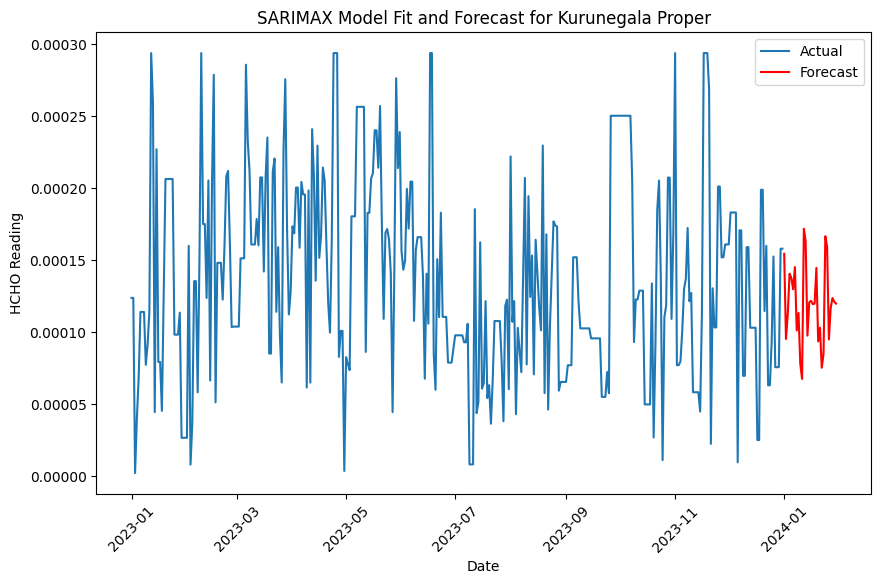

In [62]:
location_name = "Kurunegala Proper"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
kurunegala_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

                                     SARIMAX Results                                      
Dep. Variable:                       HCHO reading   No. Observations:                 1789
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood               14860.937
Date:                            Sun, 21 Apr 2024   AIC                         -29711.874
Time:                                    00:19:54   BIC                         -29684.463
Sample:                                01-01-2019   HQIC                        -29701.749
                                     - 11-24-2023                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4935   1.33e-19   3.71e+18      0.000       0.494       0.494
ma.L1         -0.7232   1.78e-19  -

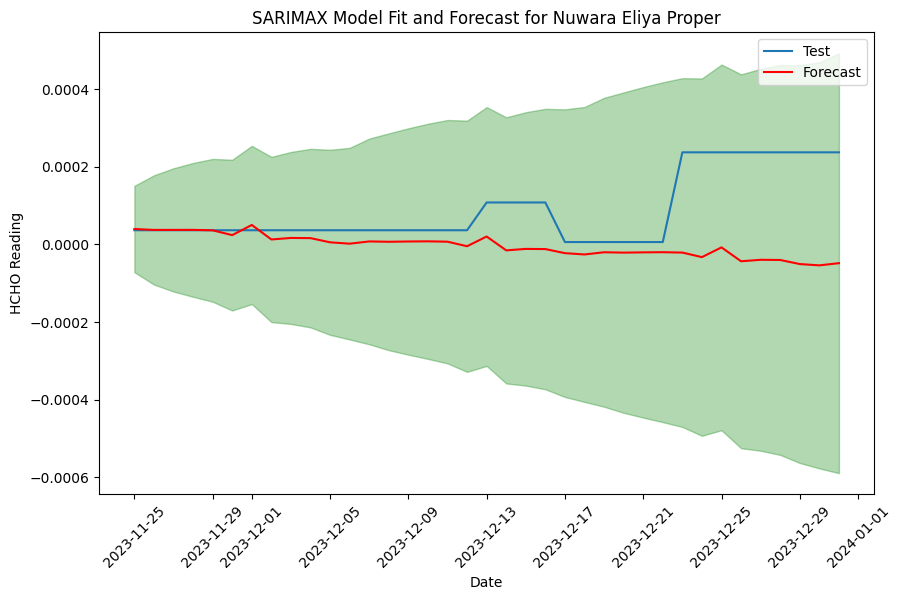

Model Evaluation
Root Mean Square Error:  0.00014205881518079114
Mean Absolute Error:  9.290753246184226e-05


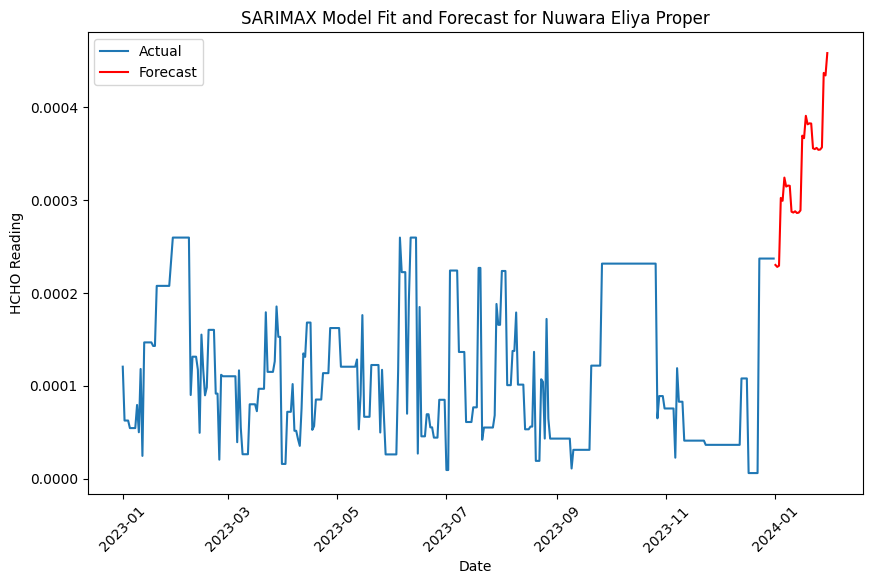

In [63]:
location_name = "Nuwara Eliya Proper"
location_data = df[df["Location"] == location_name]

# Train SARIMA and evaluate the model
manually_entered_SARIMA(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)

# Forecast for a future month (2024-01-01 to 2024-01-30)
nuwaraeliya_forecast = forecast_for_month(location_data, (1, 1, 1), (1, 1, 1, 12), location_name)